In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
from matplotlib.colors import LogNorm
from os.path import join
import torch.quantization as tq
from torch.quantization import QuantStub, DeQuantStub
import copy
import os
import wandb
from copy import deepcopy
from typing import List, Tuple
import time

# from google.colab import drive
# drive.mount("/content/drive")

/mnt/home/fgarcia/py_venves/camels/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/mnt/home/fgarcia/py_venves/camels/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened becau

In [2]:
# !ls drive/MyDrive/classes/COMSE6998/

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data_loc = "drive/MyDrive/classes/COMSE6998/"
data_loc = "./"

In [4]:
print(device)

cuda


In [5]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [6]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()

Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



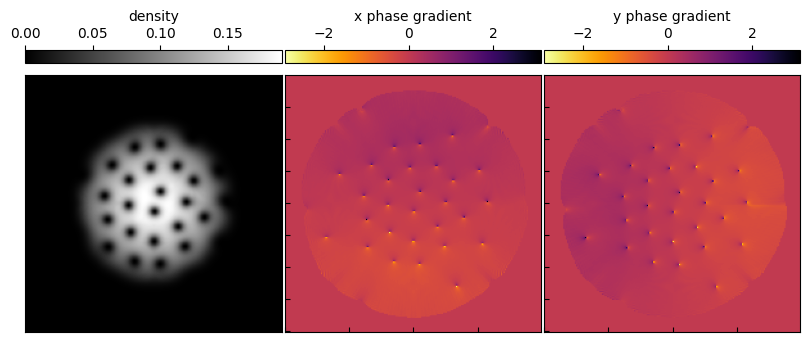

In [7]:
# Visualize an example
idx = 1
fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=100)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# Calculate shared vmin and vmax for phase gradients
vmin_phase = np.min(train_data["phase_gradients"][idx, :])
vmax_phase = np.max(train_data["phase_gradients"][idx, :])

im1 = ax[0].imshow(train_data["densities"][idx], cmap="gray", origin="lower")
cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04, location="top")
cbar1.set_label("density")
im2 = ax[1].imshow(
    train_data["phase_gradients"][idx, 0],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04, location="top")
cbar2.set_label("x phase gradient")
im3 = ax[2].imshow(
    train_data["phase_gradients"][idx, 1],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar3 = fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04, location="top")
cbar3.set_label("y phase gradient")

# remove tick label, but preserve marks
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

plt.savefig(
    os.path.join(data_loc, "finalPlot_training_set.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

# Custom Datasets/Dataloaders

In [8]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        log_eps: added before log() for numerical stability
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps

    def __len__(self):
        return self.densities.size(0)

    def __getitem__(self, idx):
        density = self.densities[idx]
        density = torch.log(density + self.log_eps)
        phase_grad = self.phase_grads[idx]
        mask = self.masks[idx]
        return density, phase_grad, mask


train_dataset = BecDataset(
    train_data["densities"], train_data["phase_gradients"], train_data["masks"]
)
val_dataset = BecDataset(
    val_data["densities"], val_data["phase_gradients"], val_data["masks"]
)
test_dataset = BecDataset(
    test_data["densities"], test_data["phase_gradients"], test_data["masks"]
)

# UNET Definition

In [9]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum=0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=0.2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            # print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        # print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
        self,
        channels,
        bilinear=True,
        add_skip=True,
        out_channels=1,
        wrap_angles=False,
        verbose=False,
    ):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            # Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList(
                [
                    Down(channels[i], channels[i + 1])
                    for i in range(1, len(channels) - 1)
                ]
                + [Down(channels[-1], channels[-1])]
            )
            self.ups = nn.ModuleList(
                [
                    Up(2 * channels[i + 1], channels[i], bilinear, add_skip)
                    for i in range(len(channels) - 2, 0, -1)
                ]
                + [Up(2 * channels[1], channels[1], bilinear, add_skip)]
            )
        else:
            self.downs = nn.ModuleList(
                [
                    Down(channels[i], channels[i + 1])
                    for i in range(1, len(channels) - 1)
                ]
            )
            self.ups = nn.ModuleList(
                [
                    Up(channels[i + 1], channels[i], bilinear, add_skip)
                    for i in range(len(channels) - 2, 0, -1)
                ]
            )
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        # Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2 * torch.pi
            x = F.relu(x) - torch.pi
        return x

# Training


In [10]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )


def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu"):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(val_loader, model, device=device)
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        print(
            f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}"
        )

In [11]:
def mse_with_mask(outputs, targets, masks, keep_first_dim=False):
    """
    # Custom Loss function
    # Ignores losses for masked out regions (mask = 1), as these are
    # Low density regions and we don't care whether we get them right or not
    """
    if keep_first_dim:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks), dim=(-1, -2, -3))
    else:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks))


# ______
batch_size = 8
epochs = 10

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_dataset, num_workers=2)
test_loader = DataLoader(test_dataset, num_workers=2)

unet = UNet(channels=[1, 8, 16, 32, 64, 128, 256, 512], out_channels=2, verbose=False)

optimizer = optim.Adam(unet.parameters(), lr=1e-3)

train_model(train_loader, unet, mse_with_mask, optimizer, epochs=epochs, device=device)

Epoch 1 Train Loss: 0.03836662133061697, Val Loss: 0.011624566279351711
Epoch 2 Train Loss: 0.006043148849765578, Val Loss: 0.004143844824284315
Epoch 3 Train Loss: 0.003778569675641992, Val Loss: 0.0032794803846627474
Epoch 4 Train Loss: 0.0030581220090093596, Val Loss: 0.002855573780834675
Epoch 5 Train Loss: 0.002640770824019989, Val Loss: 0.0024408854078501463
Epoch 6 Train Loss: 0.0023455067467506208, Val Loss: 0.0022009334061294794
Epoch 7 Train Loss: 0.002229809352669806, Val Loss: 0.0022650284226983786
Epoch 8 Train Loss: 0.0020362677880459363, Val Loss: 0.0019266152521595359
Epoch 9 Train Loss: 0.0018678535651859072, Val Loss: 0.001784288208000362
Epoch 10 Train Loss: 0.0018201030241990729, Val Loss: 0.00171495764516294


In [12]:
inputs, predictions, truths, masks = predict(test_loader, unet, device=device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim=True)
total_error_orig = errors.mean().item()
print(f"Test MSE: {errors.mean().item()}")

Test MSE: 0.001699452055618167


Text(0, 0.5, 'Count (log scale)')

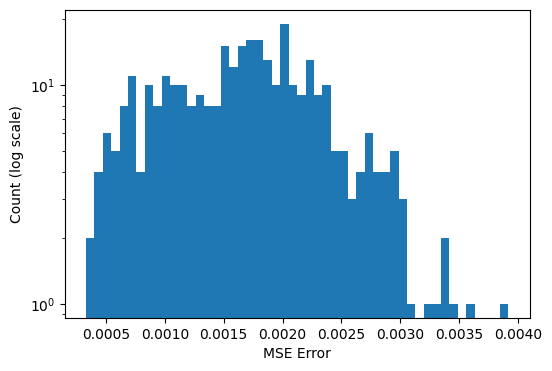

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.hist(errors.cpu().numpy(), bins=50, log=True)
ax.set_xlabel("MSE Error")
ax.set_ylabel("Count (log scale)")

In [14]:
torch.save(unet.state_dict(), "unet_original.pth")

In [ ]:
def quantize_unet_per_tensor(model):
    """
    Per-Tensor Quantization (Simple but Crude)
    - One scale factor per tensor
    - Fast but loses precision for weights with varying magnitudes
    - NOT RECOMMENDED for most applications

    Args:
        model: PyTorch model to quantize

    Returns:
        Quantized model (all operations on CPU)
    """
    model = deepcopy(model).cpu().eval()

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            # Quantize weights
            w = module.weight.data
            scale = w.abs().max() / 127.0
            if scale > 0:
                w_q = torch.round(w / scale).clamp(-128, 127)
                module.weight.data = w_q * scale

            # Quantize bias
            if module.bias is not None:
                b = module.bias.data
                b_scale = b.abs().max() / 127.0
                if b_scale > 0:
                    b_q = torch.round(b / b_scale).clamp(-128, 127)
                    module.bias.data = b_q * b_scale

    return model


def quantize_unet_per_channel(model, bits=8):
    """
    Per-Channel Quantization (Better Quality)
    - One scale factor per output channel
    - Much better accuracy than per-tensor
    - Good compression with minimal quality loss

    Args:
        model: PyTorch model to quantize
        bits: Number of bits for quantization (default: 8)

    Returns:
        Quantized model (all operations on CPU)
    """
    model = deepcopy(model).cpu().eval()

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            weight = module.weight.data  # Shape: [out_channels, in_channels, H, W]

            # Per-channel quantization (one scale per output channel)
            scales = []
            quantized_weights = []

            for c in range(weight.shape[0]):
                channel_weight = weight[c]

                # Compute scale for this channel
                scale = channel_weight.abs().max() / (2 ** (bits - 1) - 1)
                scale = max(scale, 1e-8)  # Avoid division by zero

                # Quantize
                w_q = torch.round(channel_weight / scale).clamp(
                    -(2 ** (bits - 1)), 2 ** (bits - 1) - 1
                )

                scales.append(scale)
                quantized_weights.append(w_q)

            # Reconstruct weight
            quantized_weights = torch.stack(quantized_weights, dim=0)
            scales = torch.tensor(scales).view(-1, 1, 1, 1)

            module.weight.data = quantized_weights * scales
            module.register_buffer("weight_scales", scales.squeeze())

            # Quantize bias (per-element is fine since it's 1D)
            if module.bias is not None:
                bias = module.bias.data
                bias_scale = bias.abs().max() / (2 ** (bits - 1) - 1)
                bias_scale = max(bias_scale, 1e-8)

                bias_q = torch.round(bias / bias_scale).clamp(
                    -(2 ** (bits - 1)), 2 ** (bits - 1) - 1
                )
                module.bias.data = bias_q * bias_scale

    return model


def quantize_unet_mixed_precision(model):
    """
    Mixed Precision Quantization (Best Accuracy)
    - Keeps critical layers (first and last) in float32
    - Quantizes middle layers to int8 per-channel
    - Best accuracy with some compression

    Args:
        model: PyTorch UNet model to quantize

    Returns:
        Quantized model (all operations on CPU)
    """
    model = deepcopy(model).cpu().eval()

    # Get all conv layers
    conv_modules = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_modules.append((name, module))

    print(f"Found {len(conv_modules)} Conv2d layers")

    # Keep first 2 and last 2 layers in float32
    skip_first = 2
    skip_last = 2

    for idx, (name, module) in enumerate(conv_modules):
        # Skip first and last layers (keep in float32)
        if idx < skip_first or idx >= len(conv_modules) - skip_last:
            print(f"  Keeping {name} in float32")
            continue

        # Quantize this layer (per-channel)
        weight = module.weight.data

        scales = []
        quantized_weights = []

        for c in range(weight.shape[0]):
            channel_weight = weight[c]
            scale = channel_weight.abs().max() / 127.0
            scale = max(scale, 1e-8)

            w_q = torch.round(channel_weight / scale).clamp(-128, 127)
            scales.append(scale)
            quantized_weights.append(w_q)

        quantized_weights = torch.stack(quantized_weights, dim=0)
        scales = torch.tensor(scales).view(-1, 1, 1, 1)

        module.weight.data = quantized_weights * scales

        # Quantize bias
        if module.bias is not None:
            bias = module.bias.data
            bias_scale = bias.abs().max() / 127.0
            bias_scale = max(bias_scale, 1e-8)
            bias_q = torch.round(bias / bias_scale).clamp(-128, 127)
            module.bias.data = bias_q * bias_scale

    return model


print("Quantizing with per-tensor...")
quantized_per_tensor = quantize_unet_per_tensor(unet)

print("Quantizing with per-channel...")
quantized_per_channel = quantize_unet_per_channel(unet, bits=8)


print("Quantizing with mixed precision...")
quantized_mixed = quantize_unet_mixed_precision(unet)


torch.save(quantized_per_channel.state_dict(), "unet_per_channel_int8.pth")
torch.save(quantized_mixed.state_dict(), "unet_mixed_precision.pth")
torch.save(quantized_per_tensor.state_dict(), "unet_per_tensor.pth")



Quantizing with per-tensor...
Quantizing with per-channel...
Quantizing with mixed precision...
Found 31 Conv2d layers
  Keeping inc.double_conv.0 in float32
  Keeping inc.double_conv.3 in float32
  Keeping ups.6.conv.double_conv.3 in float32
  Keeping outc.conv in float32


In [21]:
test_loader_cpu = DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=2
)
preds_orig = predictions.cpu()

In [22]:
def save_quantized_model_per_channel(model, filepath):
    """
    Save with per-channel quantization (properly stores int8)
    """
    state_dict = model.state_dict()
    quantized_state = {}

    for name, param in state_dict.items():
        if "weight" in name and param.dim() == 4:  # Conv2d weights
            # Per-channel quantization
            out_channels = param.shape[0]
            scales = []
            quantized_channels = []

            for c in range(out_channels):
                channel = param[c]
                scale = channel.abs().max().item() / 127.0
                scale = max(scale, 1e-8)

                q_channel = torch.round(channel / scale).clamp(-128, 127).to(torch.int8)
                scales.append(scale)
                quantized_channels.append(q_channel)

            quantized_state[name] = torch.stack(quantized_channels, dim=0)
            quantized_state[name + "_scales"] = torch.tensor(scales)

        elif "bias" in name and param.dtype == torch.float32:
            # Quantize bias
            scale = param.abs().max().item() / 127.0
            if scale > 1e-8:
                quantized_state[name] = (
                    torch.round(param / scale).clamp(-128, 127).to(torch.int8)
                )
                quantized_state[name + "_scale"] = torch.tensor(scale)
            else:
                quantized_state[name] = param
        else:
            quantized_state[name] = param

    torch.save(quantized_state, filepath)


def save_quantized_model_per_tensor(model, filepath):
    """
    Save with per-tensor quantization (properly stores int8)
    """
    state_dict = model.state_dict()
    quantized_state = {}

    for name, param in state_dict.items():
        if param.dtype == torch.float32 and ("weight" in name or "bias" in name):
            # Quantize to int8
            scale = param.abs().max().item() / 127.0
            if scale > 1e-8:
                param_int8 = torch.round(param / scale).clamp(-128, 127).to(torch.int8)
                quantized_state[name] = param_int8
                quantized_state[name + "_scale"] = torch.tensor(scale)
            else:
                quantized_state[name] = param
        else:
            quantized_state[name] = param

    torch.save(quantized_state, filepath)


def save_quantized_model_mixed_precision(model, filepath):
    """
    Save mixed precision model (some layers float32, some int8)
     identify which layers were quantized and save them as int8
    """
    state_dict = model.state_dict()
    quantized_state = {}

    # Get list of all conv layer names
    conv_names = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_names.append(name + ".weight")

    # Determine which layers to quantize (skip first 2 and last 2)
    skip_first = 2
    skip_last = 2
    layers_to_quantize = set(
        conv_names[skip_first:-skip_last]
        if len(conv_names) > skip_first + skip_last
        else []
    )

    for name, param in state_dict.items():
        base_name = name.replace("_scales", "").replace("_scale", "")

        # Check if this is a layer we quantized
        if base_name in layers_to_quantize and "weight" in name and param.dim() == 4:
            # Per-channel quantization for quantized layers
            out_channels = param.shape[0]
            scales = []
            quantized_channels = []

            for c in range(out_channels):
                channel = param[c]
                scale = channel.abs().max().item() / 127.0
                scale = max(scale, 1e-8)

                q_channel = torch.round(channel / scale).clamp(-128, 127).to(torch.int8)
                scales.append(scale)
                quantized_channels.append(q_channel)

            quantized_state[name] = torch.stack(quantized_channels, dim=0)
            quantized_state[name + "_scales"] = torch.tensor(scales)
        else:
            # Keep float32 for non-quantized layers
            quantized_state[name] = param

    torch.save(quantized_state, filepath)

In [31]:
with torch.no_grad():
    unet_cpu = deepcopy(unet).cpu().eval()
    _, preds_orig, truths_orig, masks_orig = predict(
        test_loader_cpu, unet_cpu, device="cpu"
    )

original_error = mse_with_mask(
    preds_orig, truths_orig, masks_orig, keep_first_dim=True
).mean()

torch.save(unet_cpu.state_dict(), "unet_original.pth")
original_file_size = os.path.getsize("unet_original.pth") / (1024 * 1024)


In [ ]:

methods = {
    "Per-Tensor (8-bit)": lambda: quantize_unet_per_tensor(unet),
    "Per-Channel (8-bit)": lambda: quantize_unet_per_channel(unet, bits=8),
    "Mixed Precision": lambda: quantize_unet_mixed_precision(unet),
}

for method_name, quantize_fn in methods.items():
    print(f"\n{'='*60}")
    print(f"Testing: {method_name}")
    print(f"{'='*60}")

    quantized_model = quantize_fn().cpu().eval()

    filename = f"unet_{method_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.pth"
    torch.save(quantized_model.state_dict(), filename)

    file_size = os.path.getsize(filename) / (1024 * 1024)

    with torch.no_grad():
        _, preds_q, truths_q, masks_q = predict(
            test_loader_cpu, quantized_model, device="cpu"
        )

    error_q = mse_with_mask(
        preds_q, truths_q, masks_q, keep_first_dim=True
    ).mean()

    error_increase = ((error_q / original_error) - 1) * 100
    diff = torch.abs(preds_orig - preds_q)

    results[method_name] = {
        "error": error_q.item(),
        "error_increase": error_increase.item(),
        "file_size": file_size,
        "mean_diff": diff.mean().item(),
        "max_diff": diff.max().item(),
    }



Testing: Per-Tensor (8-bit)


NameError: name 'original_error' is not defined

In [29]:
import pandas as pd

# Convert results dictionary to DataFrame
df_results = pd.DataFrame(results).T

# Display the DataFrame
df_results

error  error_increase  file_size  mean_diff  \
original_error        0.001699        0.001699   0.001699   0.001699   
original_file_size   66.158801       66.158801  66.158801  66.158801   
Per-Tensor (8-bit)    0.001711        0.660384  66.157596   0.013873   
Per-Channel (8-bit)   0.001737        2.180672  66.184982   0.009233   
Mixed Precision       0.001705        0.355089  66.157388   0.003184   

                      max_diff  
original_error        0.001699  
original_file_size   66.158801  
Per-Tensor (8-bit)    0.444904  
Per-Channel (8-bit)   0.541134  
Mixed Precision       0.137791

COMPREHENSIVE WEIGHT VISUALIZATION


Found 31 Conv2d layers
  Keeping inc.double_conv.0 in float32
  Keeping inc.double_conv.3 in float32
  Keeping ups.6.conv.double_conv.3 in float32
  Keeping outc.conv in float32


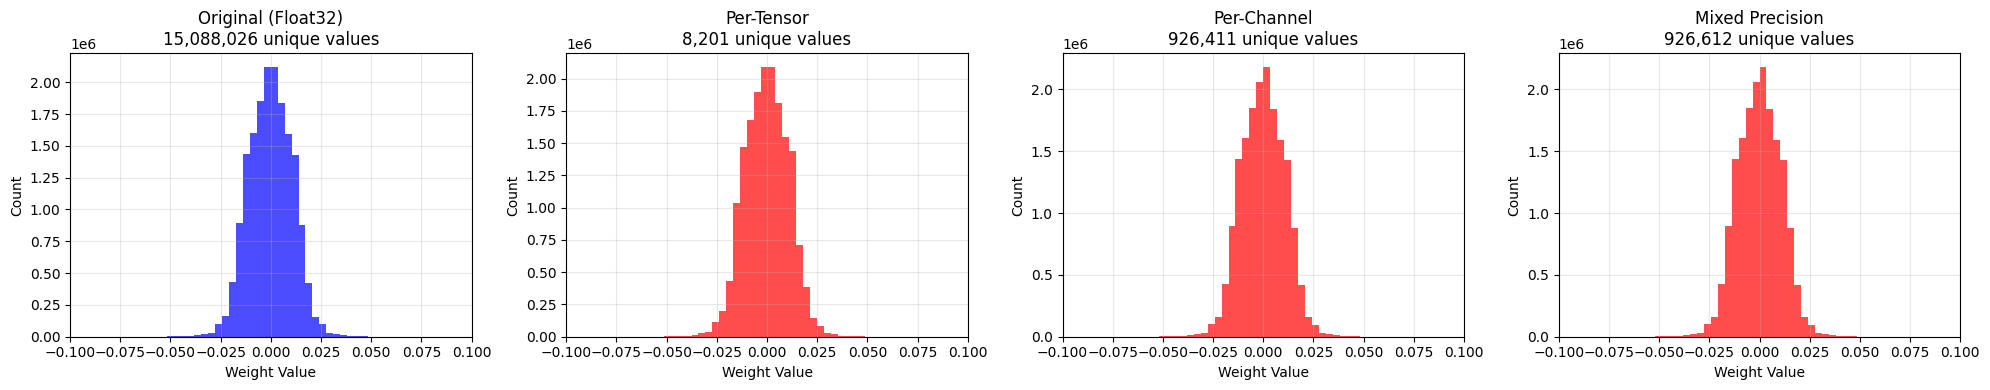

['inc.double_conv.0', 'inc.double_conv.0.bias', 'inc.double_conv.3', 'inc.double_conv.3.bias', 'downs.0.maxpool_conv.1.double_conv.0', 'downs.0.maxpool_conv.1.double_conv.0.bias', 'downs.0.maxpool_conv.1.double_conv.3', 'downs.0.maxpool_conv.1.double_conv.3.bias']


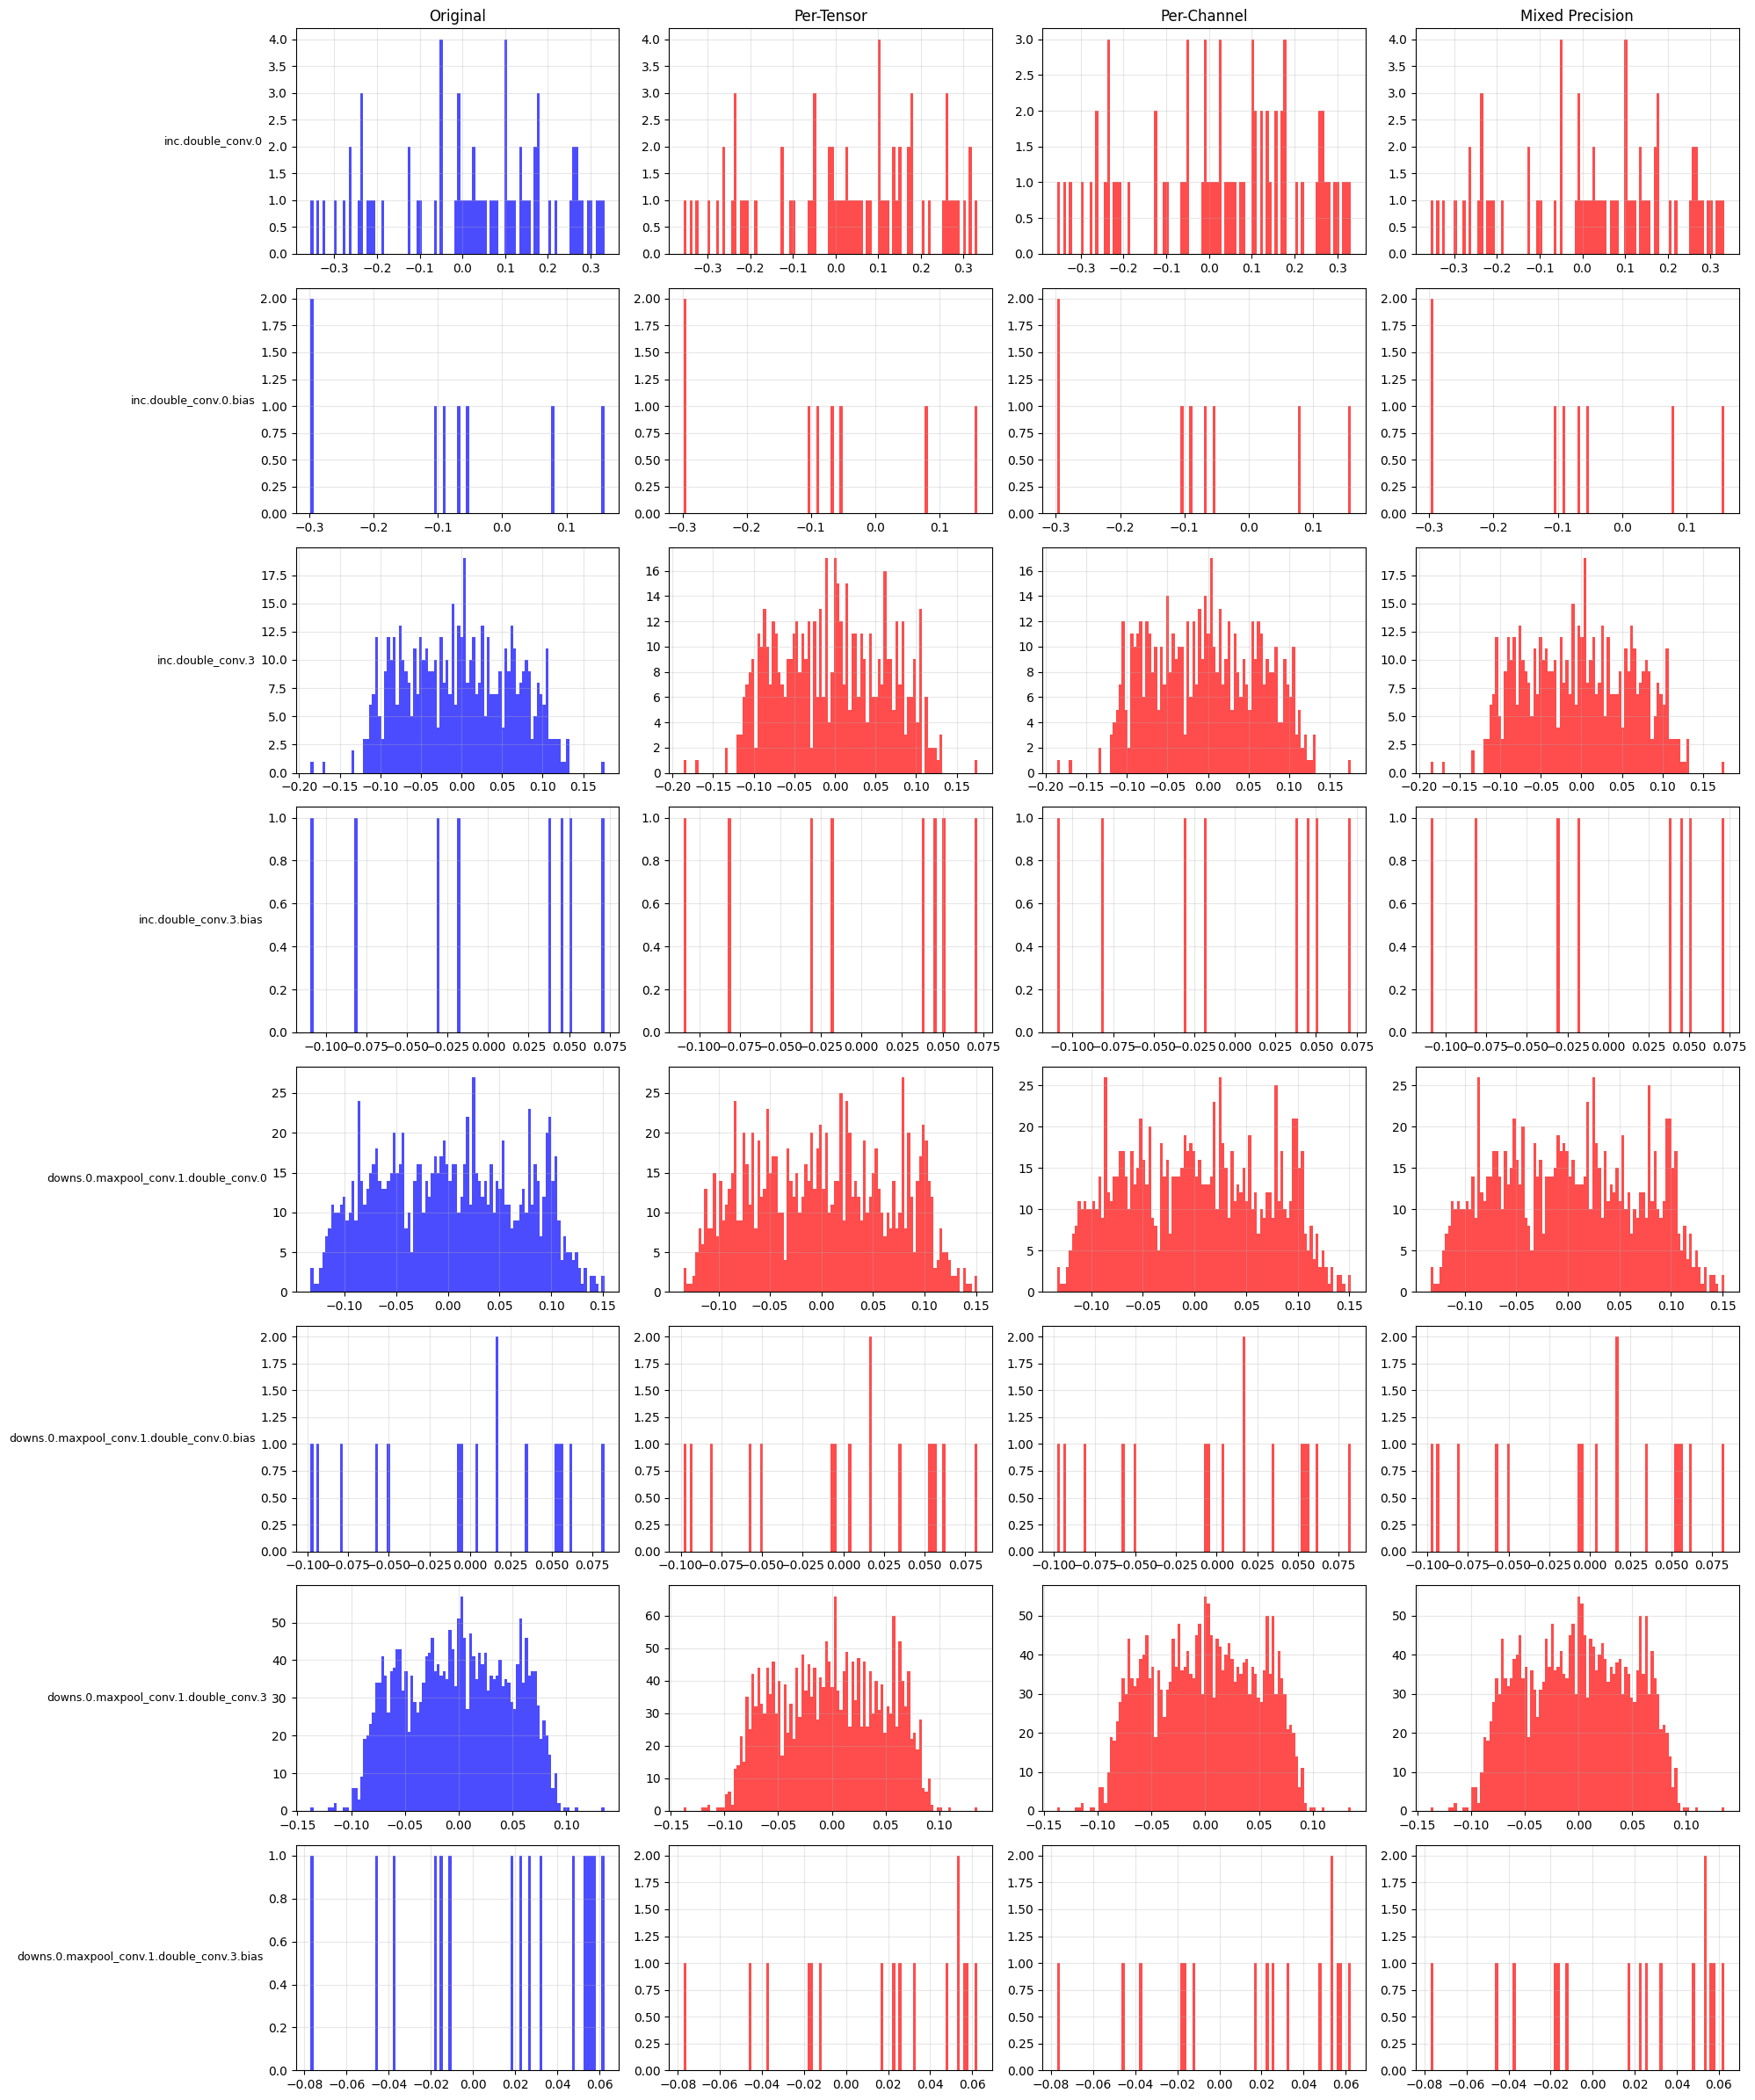

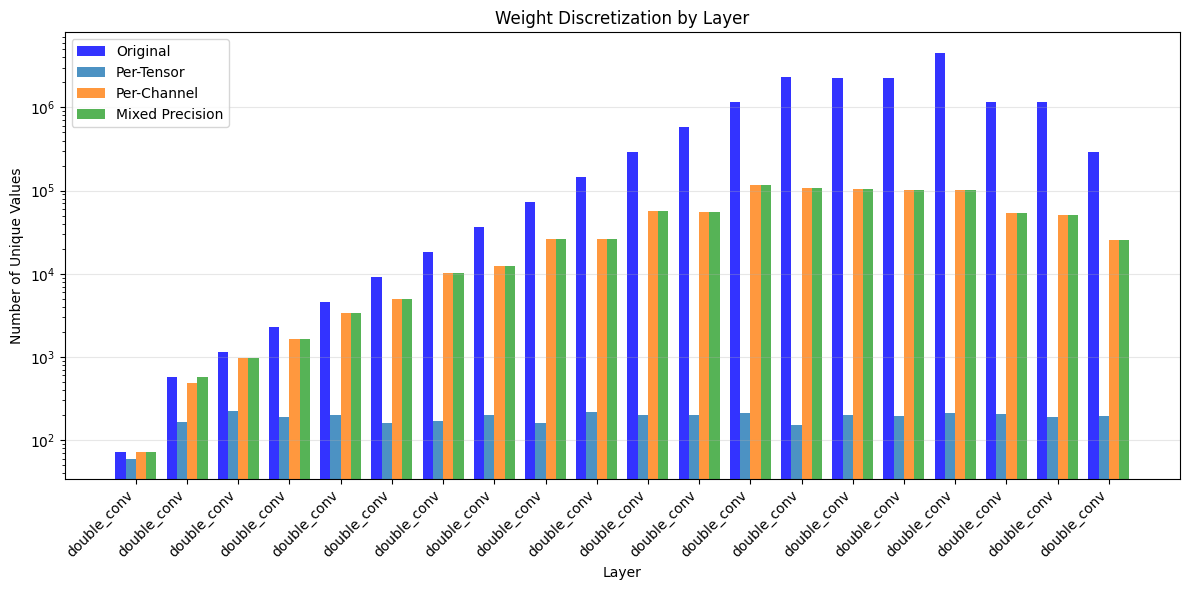

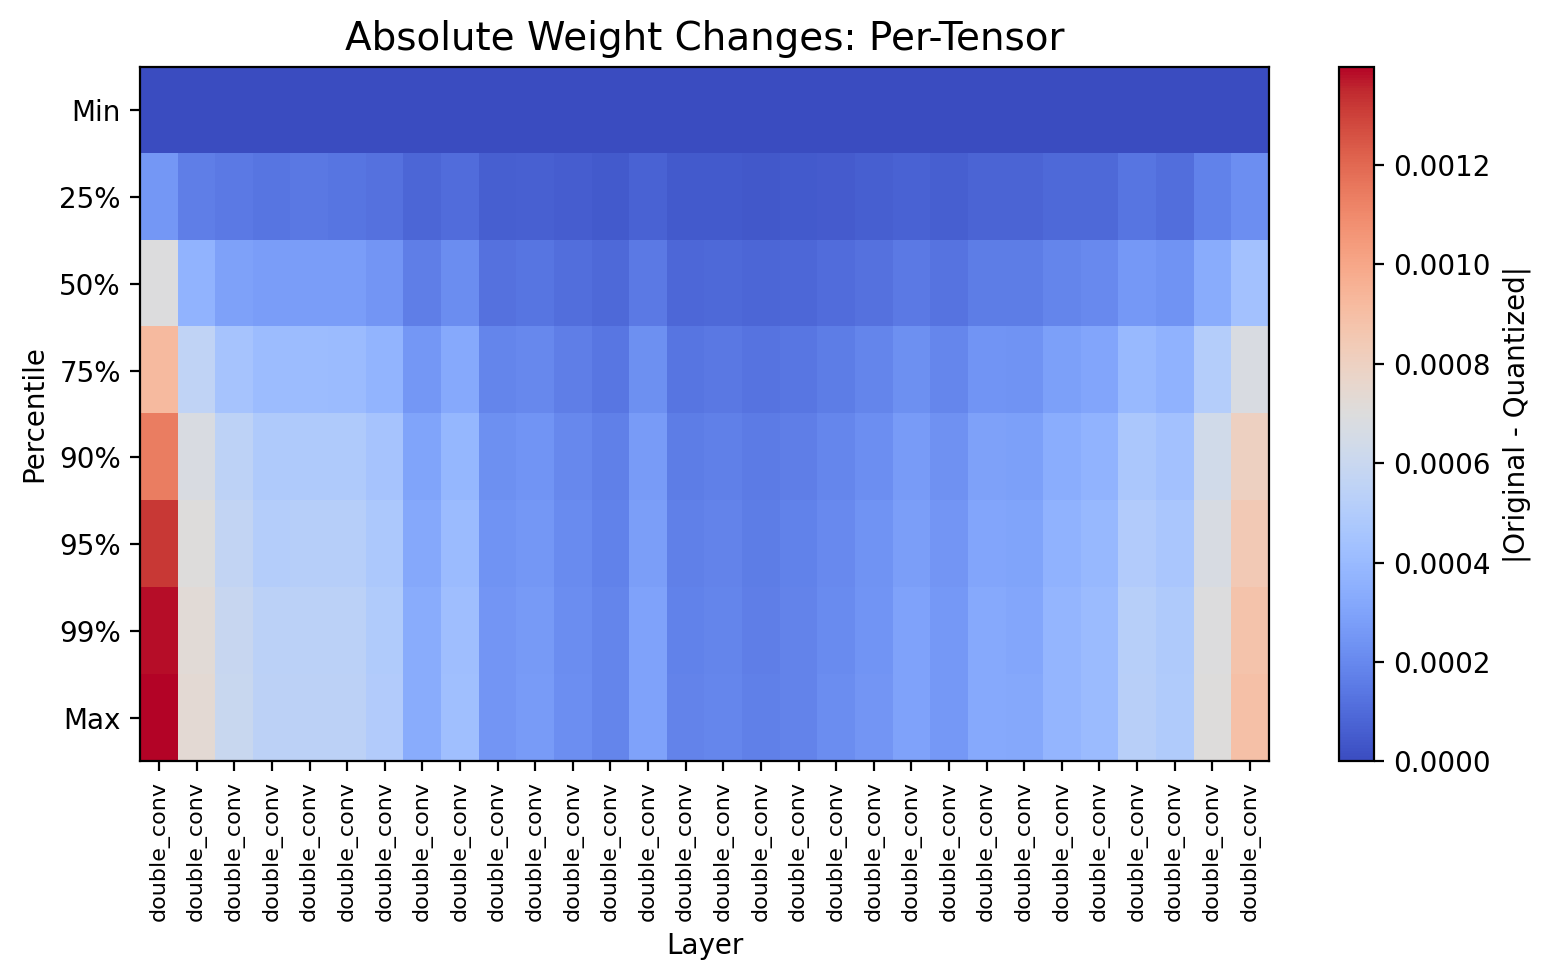

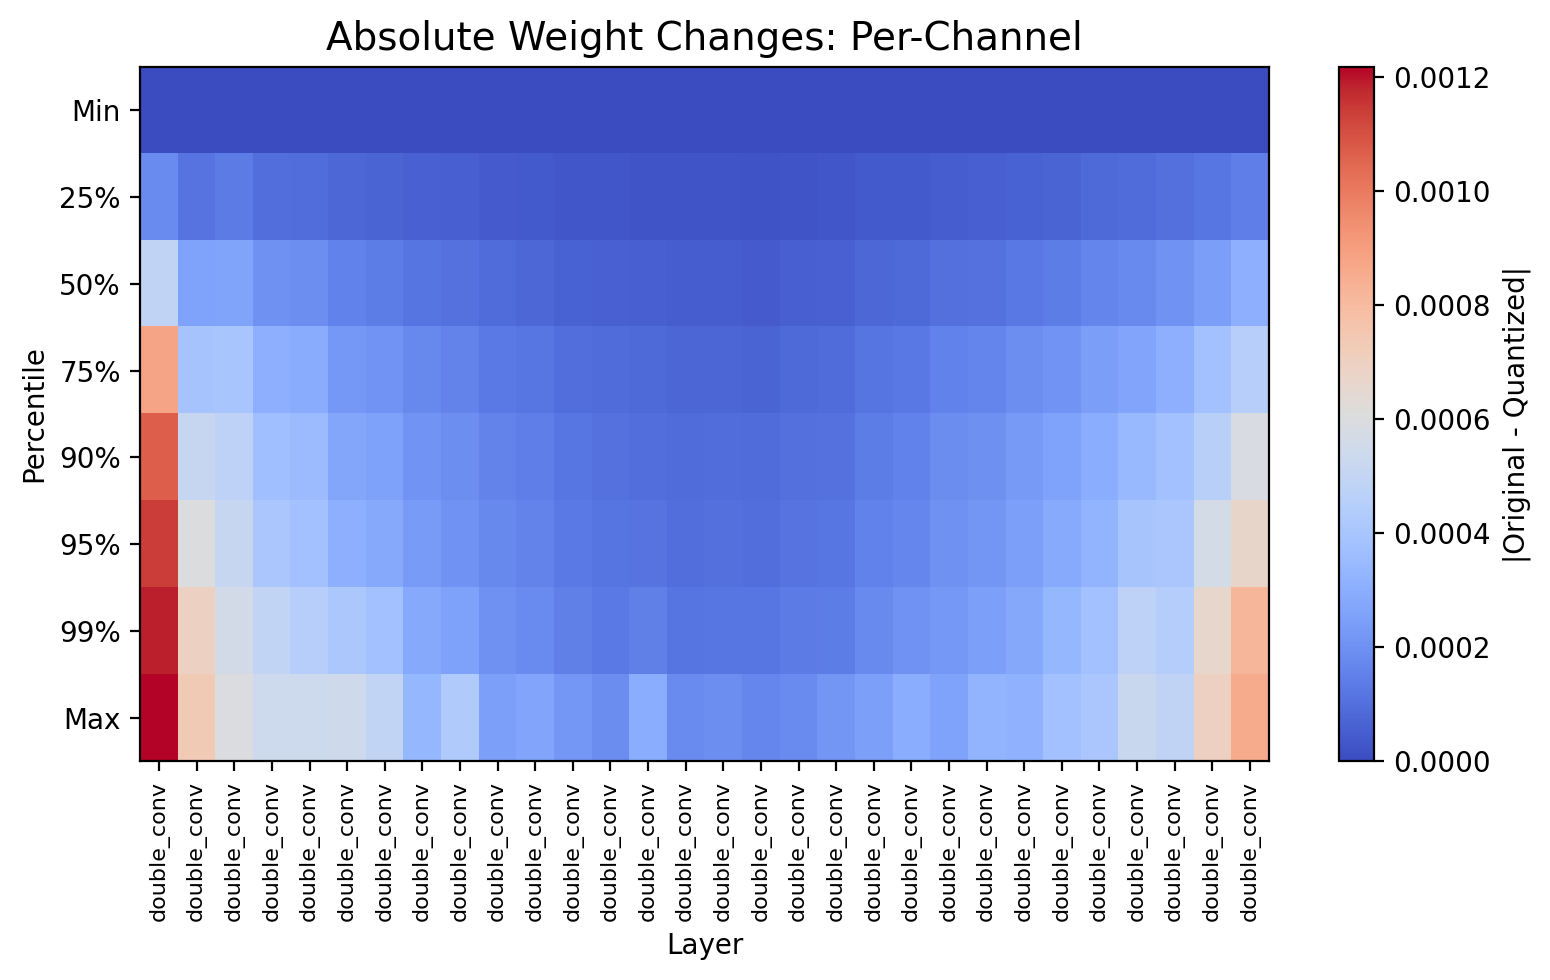

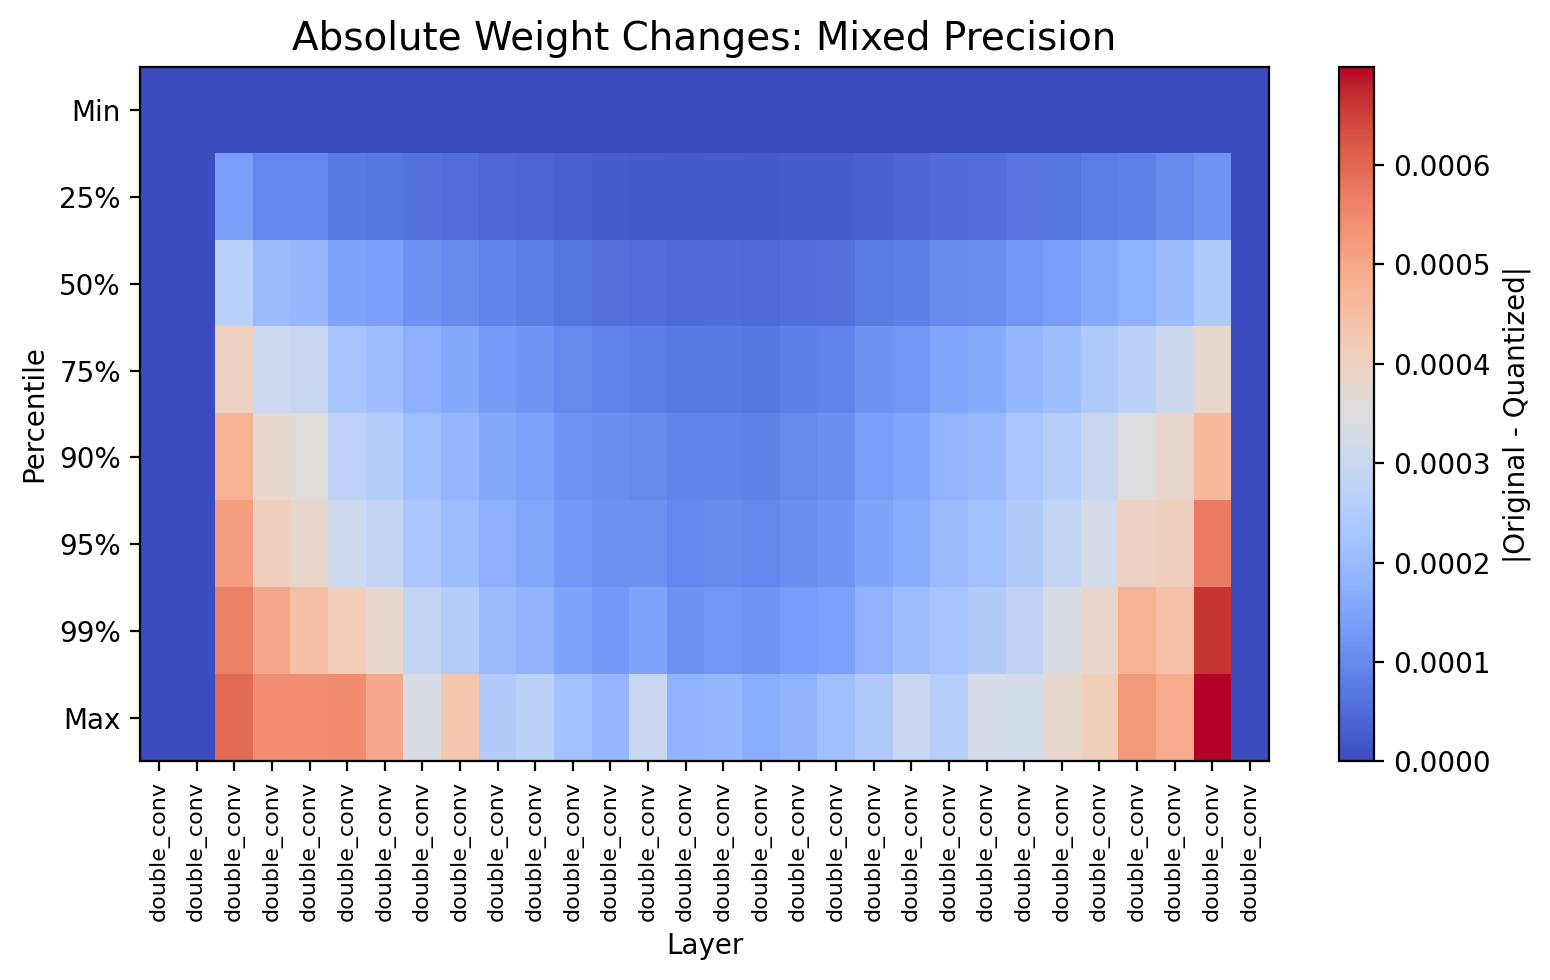


WEIGHT STATISTICS SUMMARY

Original Model:
  Total parameters: 17,305,410
  Unique values: 15,088,026
  Min: -0.359799, Max: 0.332114
  Mean: -0.000063, Std: 0.010835

Per-Tensor:
  Total parameters: 17,305,410
  Unique values: 8,201
  Min: -0.359799, Max: 0.333109
  Mean: -0.000063, Std: 0.010836
  Absolute difference from original:
    Mean: 0.00010451
    Max: 0.00141122
    Median: 0.00009994

Per-Channel:
  Total parameters: 17,305,410
  Unique values: 926,411
  Min: -0.359799, Max: 0.332114
  Mean: -0.000063, Std: 0.010836
  Absolute difference from original:
    Mean: 0.00005613
    Max: 0.00141122
    Median: 0.00005312

Mixed Precision:
  Total parameters: 17,305,410
  Unique values: 926,612
  Min: -0.359799, Max: 0.332114
  Mean: -0.000063, Std: 0.010835
  Absolute difference from original:
    Mean: 0.00005611
    Max: 0.00069885
    Median: 0.00005311


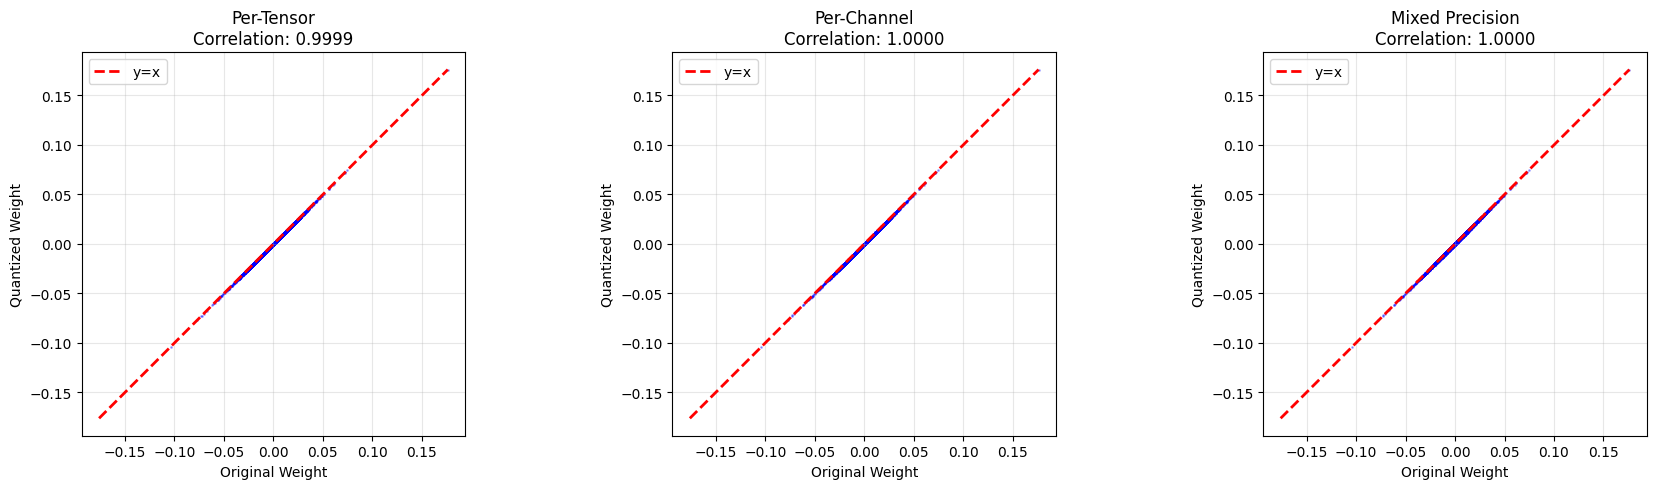

In [ ]:
def plot_weight_scatter_comparison(
    original_model,
    quantized_models_dict,
    num_samples=50000,
    save_prefix="weight_scatter",
):
    """
    Scatter plot showing original vs quantized weights
    """
    orig_weights = extract_all_weights(original_model)
    all_orig = np.concatenate([w for w in orig_weights.values()])

    # Sample if too many points
    if len(all_orig) > num_samples:
        indices = np.random.choice(len(all_orig), num_samples, replace=False)
        all_orig_sampled = all_orig[indices]
    else:
        indices = np.arange(len(all_orig))
        all_orig_sampled = all_orig

    n_methods = len(quantized_models_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=(6 * n_methods, 5))

    if n_methods == 1:
        axes = [axes]

    for idx, (method_name, model) in enumerate(quantized_models_dict.items()):
        weights = extract_all_weights(model)
        all_quant = np.concatenate([w for w in weights.values()])
        all_quant_sampled = all_quant[indices]

        # Scatter plot
        axes[idx].scatter(all_orig_sampled, all_quant_sampled, alpha=0.3, s=1, c="blue")

        # y=x line
        lim = max(abs(all_orig_sampled).max(), abs(all_quant_sampled).max())
        axes[idx].plot([-lim, lim], [-lim, lim], "r--", linewidth=2, label="y=x")

        axes[idx].set_xlabel("Original Weight")
        axes[idx].set_ylabel("Quantized Weight")
        axes[idx].set_title(
            f"{method_name}\nCorrelation: {np.corrcoef(all_orig_sampled, all_quant_sampled)[0,1]:.4f}"
        )
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
        axes[idx].set_aspect("equal")

    plt.tight_layout()
    plt.savefig(f"{save_prefix}.png", dpi=150, bbox_inches="tight")
    plt.show()


def plot_quantization_levels(
    original_model, quantized_models_dict, save_prefix="quant_levels"
):
    """
    Visualize the quantization levels/bins for each method
    """
    orig_weights = extract_all_weights(original_model)
    all_orig = np.concatenate([w for w in orig_weights.values()])

    n_methods = len(quantized_models_dict)
    fig, axes = plt.subplots(n_methods, 2, figsize=(14, 4 * n_methods))

    if n_methods == 1:
        axes = axes.reshape(1, -1)

    for idx, (method_name, model) in enumerate(quantized_models_dict.items()):
        weights = extract_all_weights(model)
        all_quant = np.concatenate([w for w in weights.values()])

        # Left: Overlaid histograms
        axes[idx, 0].hist(
            all_orig,
            bins=500,
            alpha=0.5,
            color="blue",
            label="Original",
            density=True,
            edgecolor="none",
        )
        axes[idx, 0].hist(
            all_quant,
            bins=500,
            alpha=0.5,
            color="red",
            label=method_name,
            density=True,
            edgecolor="none",
        )
        axes[idx, 0].set_xlabel("Weight Value")
        axes[idx, 0].set_ylabel("Density")
        axes[idx, 0].set_title(f"{method_name} - Distribution Overlay")
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].set_xlim(-0.3, 0.3)

        # Right: Unique quantization levels
        unique_quant = np.unique(all_quant)
        axes[idx, 1].hist(
            all_quant,
            bins=len(unique_quant),
            alpha=0.7,
            color="red",
            edgecolor="black",
            linewidth=0.5,
        )
        axes[idx, 1].set_xlabel("Weight Value")
        axes[idx, 1].set_ylabel("Count")
        axes[idx, 1].set_title(
            f"{method_name} - Quantization Bins ({len(unique_quant)} levels)"
        )
        axes[idx, 1].grid(True, alpha=0.3)

        # Add vertical lines for quantization levels (if not too many)
        if len(unique_quant) < 100:
            for level in unique_quant:
                axes[idx, 1].axvline(level, color="black", alpha=0.3, linewidth=0.5)

    plt.tight_layout()
    plt.savefig(f"{save_prefix}.png", dpi=150, bbox_inches="tight")
    plt.show()


# ============ USAGE ============


per_tensor_model = quantize_unet_per_tensor(unet)
per_channel_model = quantize_unet_per_channel(unet, bits=8)
mixed_precision_model = quantize_unet_mixed_precision(unet)

quantized_models = {
    "Per-Tensor": per_tensor_model,
    "Per-Channel": per_channel_model,
    "Mixed Precision": mixed_precision_model,
}


plot_weight_distributions(unet, quantized_models, save_prefix="unet_weights")

plot_weight_scatter_comparison(unet, quantized_models, save_prefix="unet_scatter")

In [ ]:
unet = unet.to(device)
unet.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downs): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): Batch


Generating BEC phase prediction comparisons...


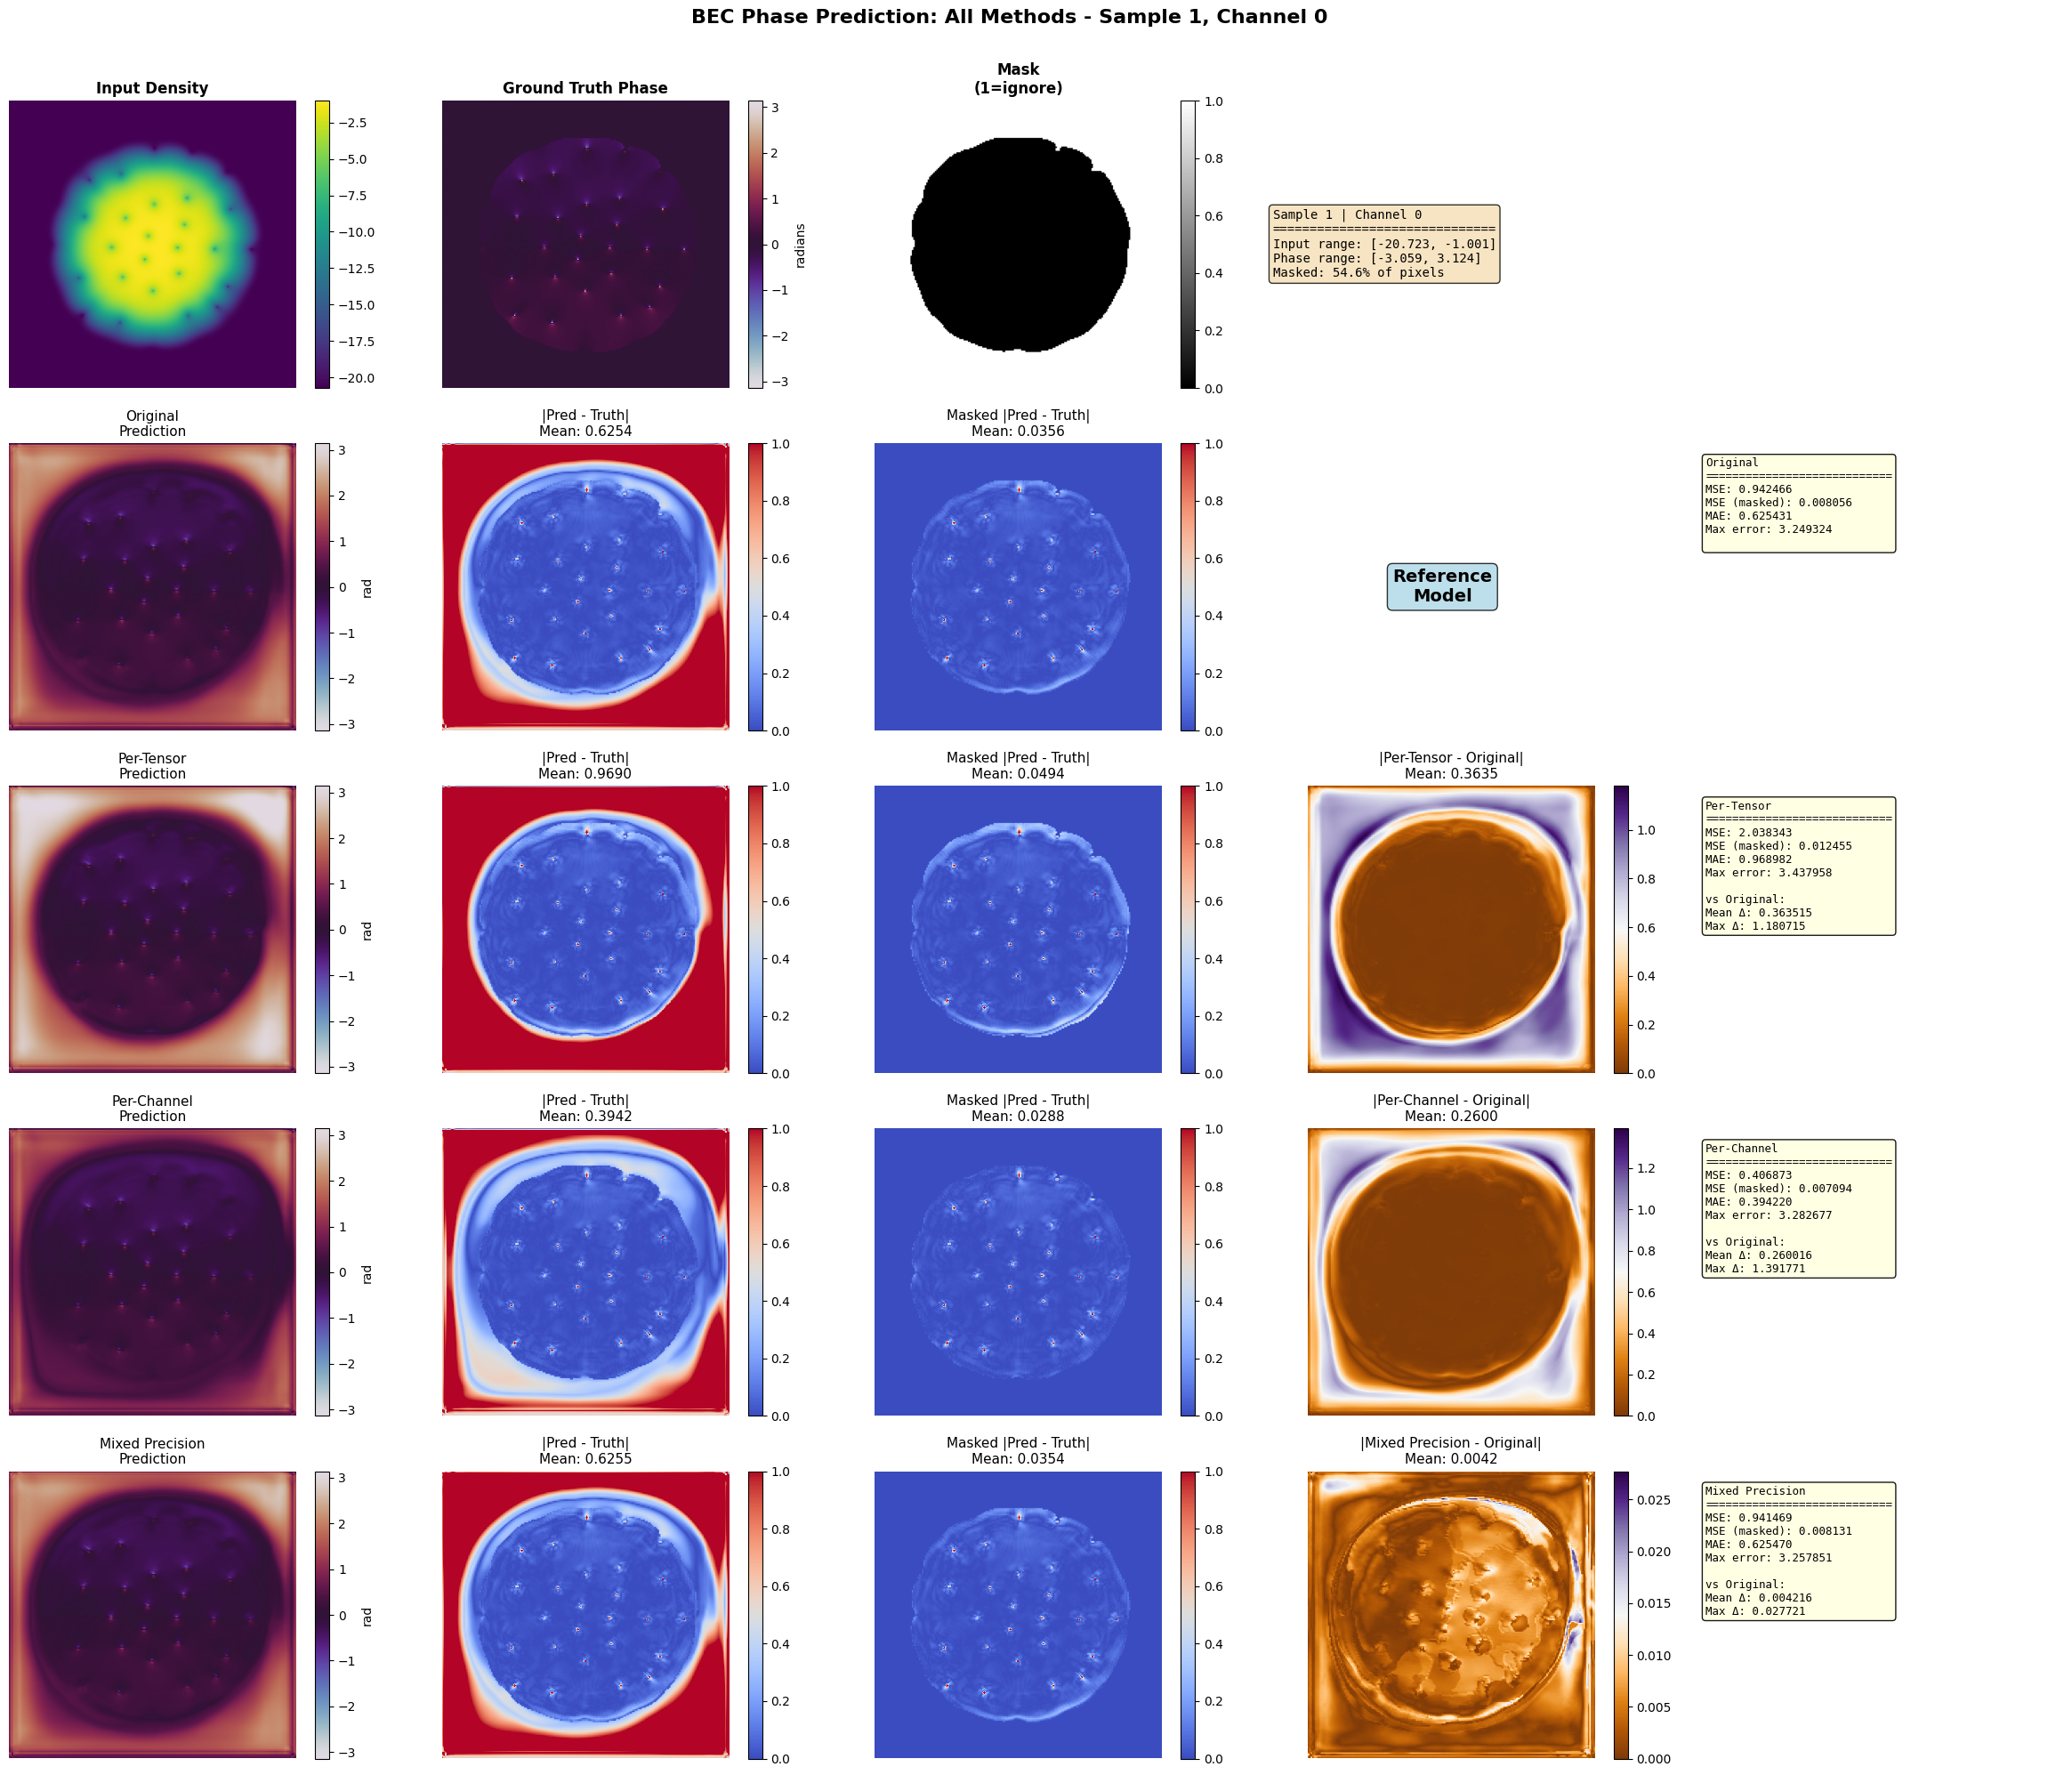

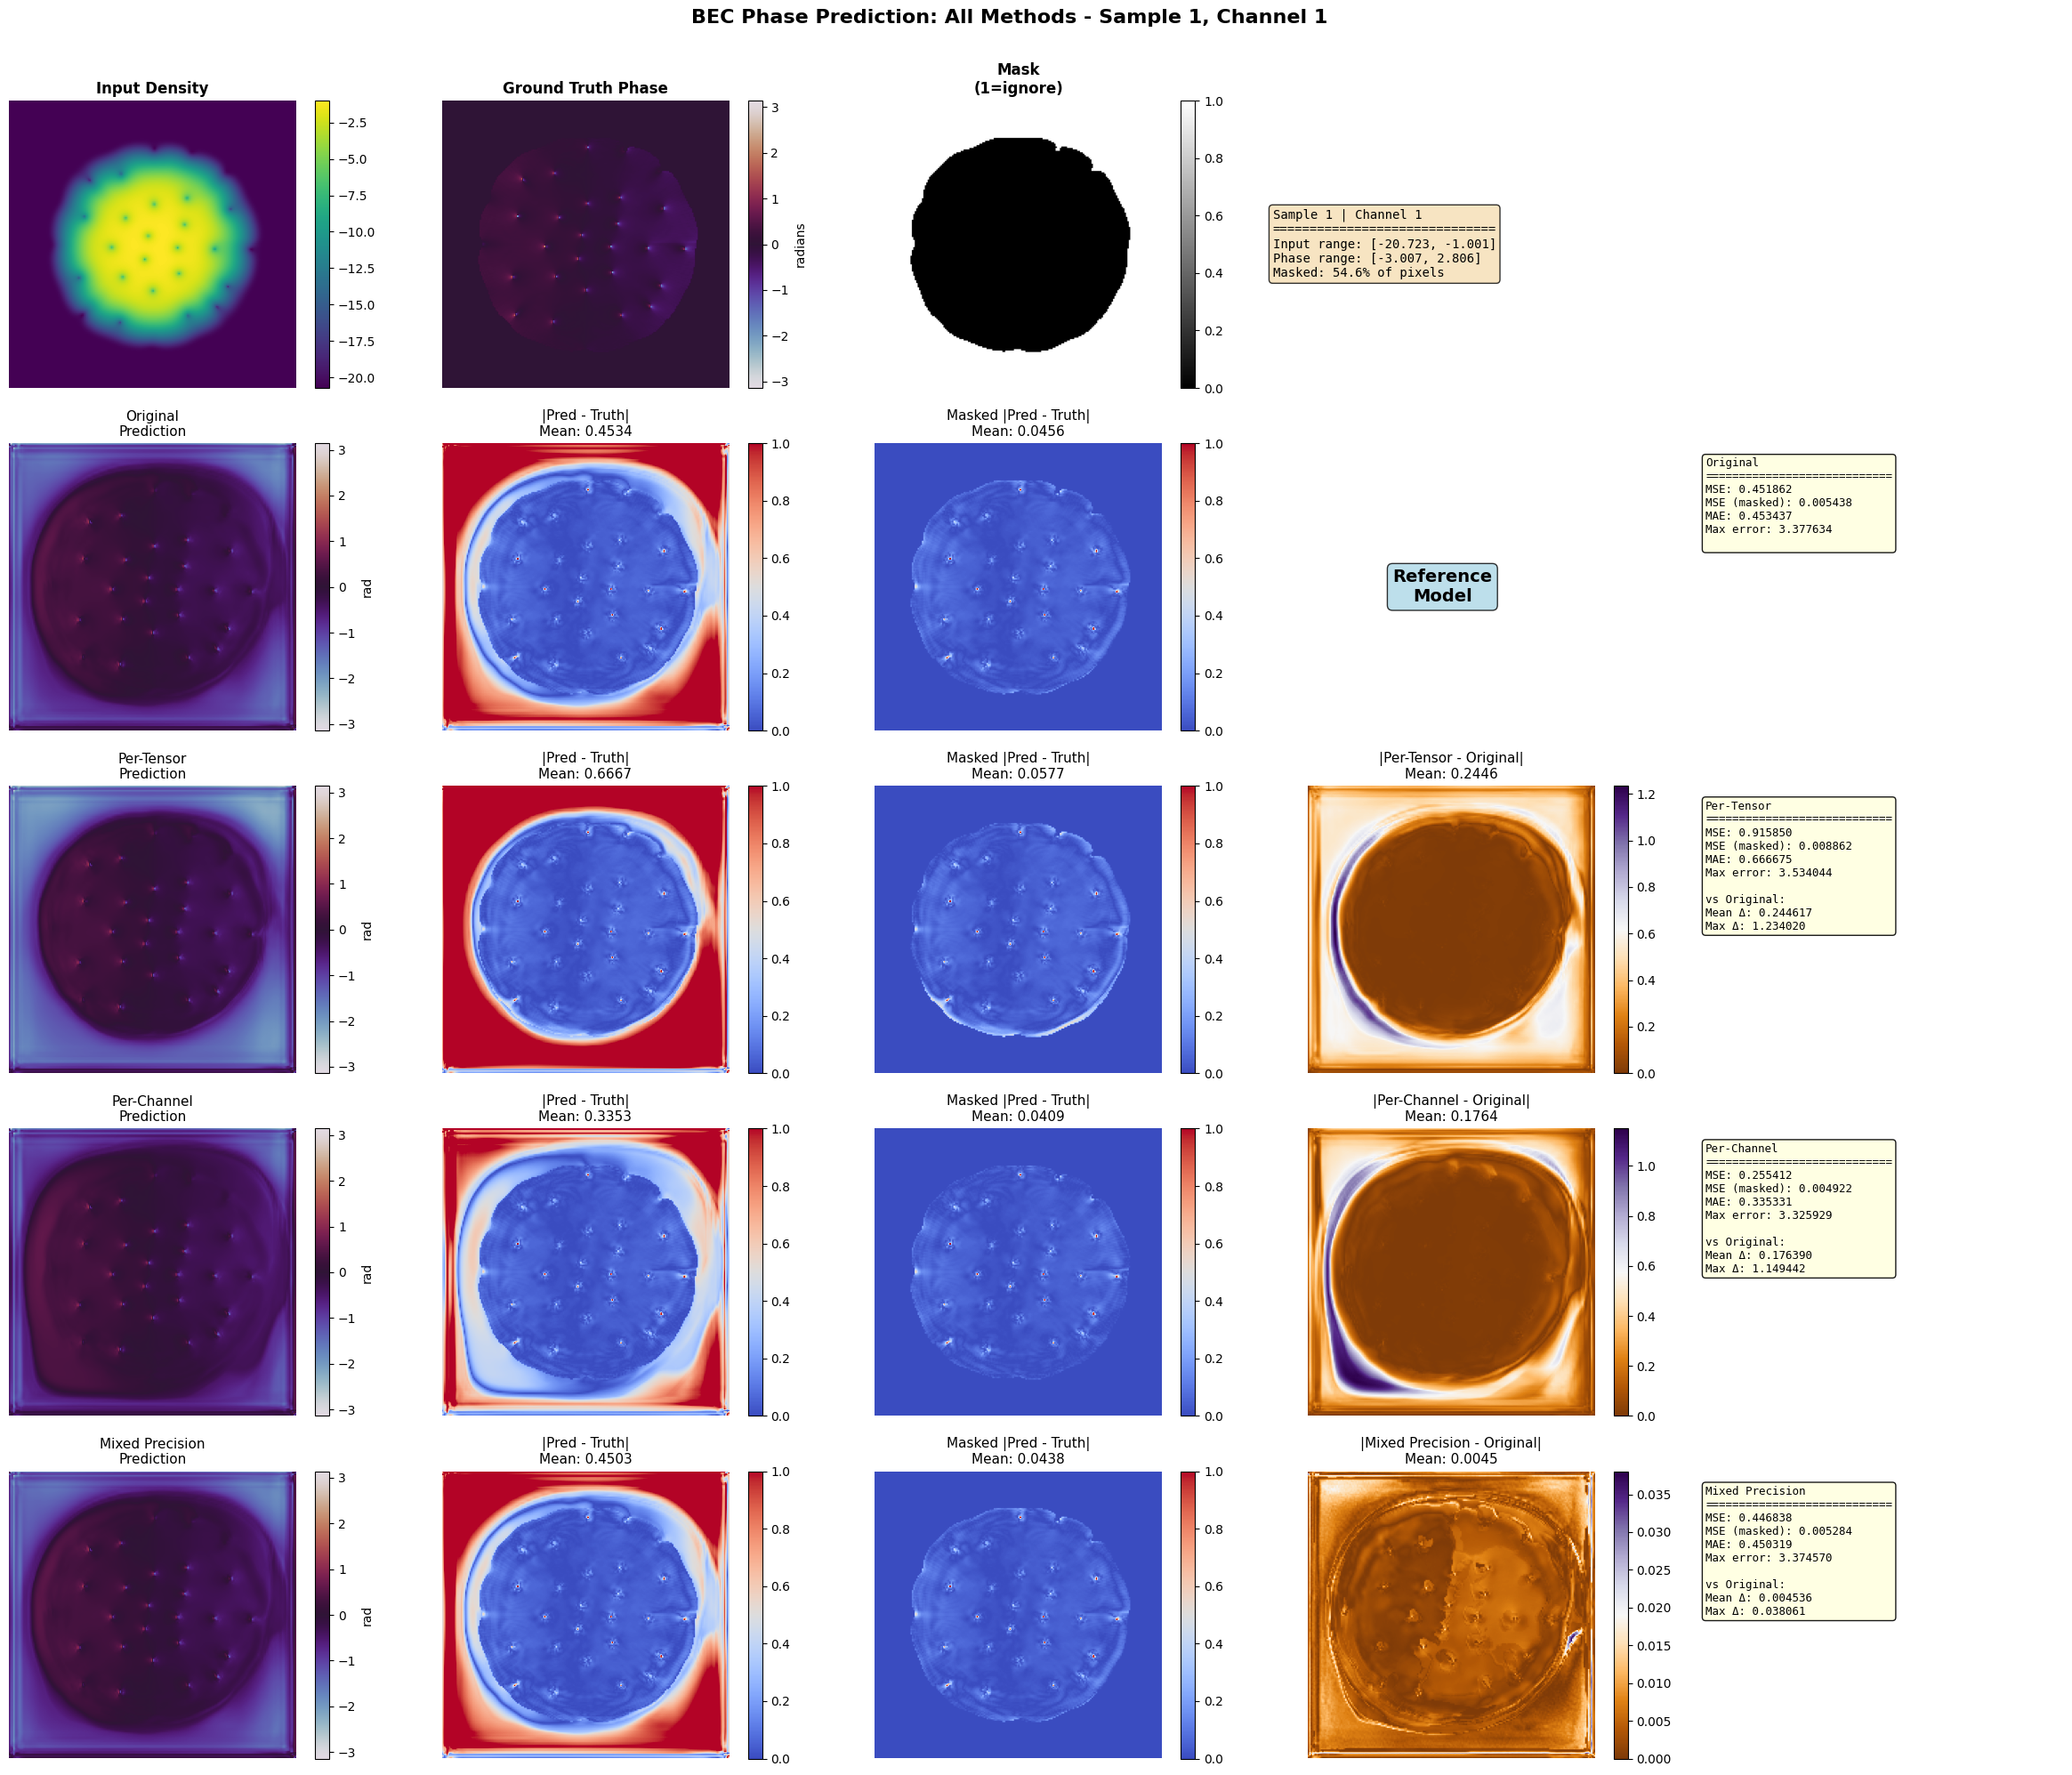


✓ Generated 1 prediction comparison plots


In [ ]:
def compare_bec_predictions_4methods(
    original_model,
    quantized_models_dict,
    test_loader,
    device="cuda",
    num_samples=1,
    save_prefix="bec_predictions",
):
    """
    Compare BEC predictions: Ground Truth, Original, Per-Tensor, Per-Channel, Mixed Precision
    """

    original_model.eval()
    for model in quantized_models_dict.values():
        model.eval()

    sample_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets, masks) in enumerate(test_loader):
            if sample_count >= num_samples:
                break

            # Get predictions from all models
            inputs_device = inputs.to(device)
            inputs_cpu = inputs.cpu()

            # Original prediction (on GPU)
            pred_original = original_model(inputs_device).cpu()

            # Quantized predictions (on CPU)
            predictions = {"Original": pred_original}
            for method_name, model in quantized_models_dict.items():
                predictions[method_name] = model(inputs_cpu)

            # Move data to numpy
            input_np = inputs[0].cpu().numpy()
            target_np = targets[0].cpu().numpy()
            mask_np = masks[0].cpu().numpy()

            predictions_np = {
                name: pred[0].cpu().numpy() for name, pred in predictions.items()
            }

            # Get number of output channels
            n_channels = target_np.shape[0]

            # Create visualization for this sample
            for ch in range(n_channels):
                n_methods = len(predictions)
                fig = plt.figure(figsize=(24, 4 * (n_methods + 1)))

                # Row 0: Input, Ground Truth, Mask, Stats
                ax = plt.subplot(n_methods + 1, 5, 1)
                im = ax.imshow(input_np[0], cmap="viridis")
                ax.set_title("Input Density", fontsize=12, fontweight="bold")
                ax.axis("off")
                plt.colorbar(im, ax=ax, fraction=0.046)

                ax = plt.subplot(n_methods + 1, 5, 2)
                im = ax.imshow(target_np[ch], cmap="twilight", vmin=-np.pi, vmax=np.pi)
                ax.set_title("Ground Truth Phase", fontsize=12, fontweight="bold")
                ax.axis("off")
                plt.colorbar(im, ax=ax, fraction=0.046, label="radians")

                ax = plt.subplot(n_methods + 1, 5, 3)
                im = ax.imshow(mask_np[0], cmap="gray", vmin=0, vmax=1)
                ax.set_title("Mask\n(1=ignore)", fontsize=12, fontweight="bold")
                ax.axis("off")
                plt.colorbar(im, ax=ax, fraction=0.046)

                # Stats box
                ax = plt.subplot(n_methods + 1, 5, 4)
                ax.axis("off")
                stats_text = f"Sample {sample_count + 1} | Channel {ch}\n"
                stats_text += "=" * 30 + "\n"
                stats_text += (
                    f"Input range: [{input_np[0].min():.3f}, {input_np[0].max():.3f}]\n"
                )
                stats_text += f"Phase range: [{target_np[ch].min():.3f}, {target_np[ch].max():.3f}]\n"
                stats_text += f"Masked: {100*mask_np[0].mean():.1f}% of pixels"
                ax.text(
                    0.05,
                    0.5,
                    stats_text,
                    fontsize=10,
                    verticalalignment="center",
                    family="monospace",
                    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
                )

                # Leave column 5 empty

                # Rows 1-N: Each model's prediction
                for row_idx, (method_name, pred_np) in enumerate(
                    predictions_np.items(), 1
                ):
                    base_col = (row_idx - 1) * 5

                    # Prediction
                    ax = plt.subplot(n_methods + 1, 5, base_col + 5 + 1)
                    im = ax.imshow(
                        pred_np[ch], cmap="twilight", vmin=-np.pi, vmax=np.pi
                    )
                    ax.set_title(f"{method_name}\nPrediction", fontsize=11)
                    ax.axis("off")
                    plt.colorbar(im, ax=ax, fraction=0.046, label="rad")

                    # Difference from ground truth
                    ax = plt.subplot(n_methods + 1, 5, base_col + 5 + 2)
                    diff_gt = np.abs(pred_np[ch] - target_np[ch])
                    im = ax.imshow(diff_gt, cmap="coolwarm", vmin=0, vmax=1)
                    ax.set_title(
                        f"|Pred - Truth|\nMean: {diff_gt.mean():.4f}", fontsize=11
                    )
                    ax.axis("off")
                    plt.colorbar(im, ax=ax, fraction=0.046)

                    # Masked difference
                    ax = plt.subplot(n_methods + 1, 5, base_col + 5 + 3)
                    masked_diff_gt = diff_gt * (1 - mask_np[0])
                    valid_pixels = (1 - mask_np[0]).sum()
                    masked_mean = (
                        masked_diff_gt.sum() / valid_pixels if valid_pixels > 0 else 0
                    )
                    im = ax.imshow(masked_diff_gt, cmap="coolwarm", vmin=0, vmax=1)
                    ax.set_title(
                        f"Masked |Pred - Truth|\nMean: {masked_mean:.4f}", fontsize=11
                    )
                    ax.axis("off")
                    plt.colorbar(im, ax=ax, fraction=0.046)

                    # Difference from original (if not original)
                    ax = plt.subplot(n_methods + 1, 5, base_col + 5 + 4)
                    if method_name == "Original":
                        ax.text(
                            0.5,
                            0.5,
                            "Reference\nModel",
                            ha="center",
                            va="center",
                            fontsize=14,
                            fontweight="bold",
                            bbox=dict(
                                boxstyle="round", facecolor="lightblue", alpha=0.8
                            ),
                        )
                        ax.axis("off")
                    else:
                        diff_orig = np.abs(pred_np[ch] - predictions_np["Original"][ch])
                        im = ax.imshow(diff_orig, cmap="PuOr", vmin=0)
                        ax.set_title(
                            f"|{method_name} - Original|\nMean: {diff_orig.mean():.4f}",
                            fontsize=11,
                        )
                        ax.axis("off")
                        plt.colorbar(im, ax=ax, fraction=0.046)

                    # Statistics box
                    ax = plt.subplot(n_methods + 1, 5, base_col + 5 + 5)
                    ax.axis("off")

                    mse = ((pred_np[ch] - target_np[ch]) ** 2).mean()
                    mse_masked = (
                        ((pred_np[ch] - target_np[ch]) ** 2) * (1 - mask_np[0])
                    ).sum() / valid_pixels
                    mae = diff_gt.mean()
                    max_err = diff_gt.max()

                    if method_name != "Original":
                        diff_from_orig = np.abs(
                            pred_np[ch] - predictions_np["Original"][ch]
                        )
                        mean_diff_orig = diff_from_orig.mean()
                        max_diff_orig = diff_from_orig.max()
                    else:
                        mean_diff_orig = 0
                        max_diff_orig = 0

                    stats = f"{method_name}\n"
                    stats += "=" * 28 + "\n"
                    stats += f"MSE: {mse:.6f}\n"
                    stats += f"MSE (masked): {mse_masked:.6f}\n"
                    stats += f"MAE: {mae:.6f}\n"
                    stats += f"Max error: {max_err:.6f}\n"
                    if method_name != "Original":
                        stats += f"\nvs Original:\n"
                        stats += f"Mean Δ: {mean_diff_orig:.6f}\n"
                        stats += f"Max Δ: {max_diff_orig:.6f}"

                    ax.text(
                        0.05,
                        0.95,
                        stats,
                        fontsize=9,
                        verticalalignment="top",
                        family="monospace",
                        bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.9),
                    )

                plt.suptitle(
                    f"BEC Phase Prediction: All Methods - Sample {sample_count + 1}, Channel {ch}",
                    fontsize=16,
                    fontweight="bold",
                    y=0.995,
                )
                plt.tight_layout(rect=[0, 0, 1, 0.99])
                plt.savefig(
                    f"{save_prefix}_sample{sample_count+1}_ch{ch}.png",
                    dpi=150,
                    bbox_inches="tight",
                )
                plt.show()

            sample_count += 1

    print(f"\n✓ Generated {sample_count} prediction comparison plots")


# Run the BEC prediction comparison
print("\nGenerating BEC phase prediction comparisons...")
compare_bec_predictions_4methods(
    unet,
    quantized_models,
    test_loader,
    device=device,
    num_samples=1,
    save_prefix="bec_4methods",
)

### quantization post training (good for inference)

In [ ]:
# First, define a function to collect activations (modify for your data)
def collect_activations_for_unet(model, data_loader, device, num_batches=10):
    """Collect activations from the trained UNet model"""
    model.eval()

    # Initialize lists to store activations
    model.input_activations = []

    # Initialize activation collectors for all Conv layers
    def init_activation_collector(module):
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            module.activations = []

    model.apply(init_activation_collector)

    # Define hook functions
    def input_hook(module, input):
        model.input_activations.append(input[0].detach().cpu().numpy())

    def activation_hook(module, input, output):
        if hasattr(module, "activations"):
            module.activations.append(output.detach().cpu().numpy())

    # Register hooks
    hooks = []

    # Hook for input
    input_hook_handle = model.register_forward_pre_hook(input_hook)
    hooks.append(input_hook_handle)

    # Hooks for all Conv layers
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            hook_handle = module.register_forward_hook(activation_hook)
            hooks.append(hook_handle)

    # Collect activations
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if batch_idx >= num_batches:
                break

            # Assuming your dataset returns (data, target, mask)
            # Adjust based on your actual dataset structure
            if len(batch) == 3:
                data, _, _ = batch
            elif len(batch) == 2:
                data, _ = batch
            else:
                data = batch[0]

            data = data.to(device)
            _ = model(data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Convert lists to numpy arrays
    if model.input_activations:
        model.input_activations = np.concatenate(model.input_activations)

    # Convert layer activations
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)) and hasattr(
            module, "activations"
        ):
            if module.activations:
                module.activations = np.concatenate(module.activations)
            else:
                # If no activations were collected (shouldn't happen), create empty array
                module.activations = np.array([])

    return model

In [ ]:
def quantize_unet_weights_simple(model: nn.Module):
    """Simple brute-force quantization - modifies in-place"""
    model = copy.deepcopy(model)

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            # Calculate scale
            max_weight = torch.max(torch.abs(module.weight.data))
            scale = 127.0 / max_weight.item() if max_weight > 0 else 1.0

            # Apply quantization
            module.weight.scale = scale
            with torch.no_grad():
                module.weight.data = (module.weight.data * scale).round()
                module.weight.data = torch.clamp(module.weight.data, -128, 127)

            print(f"Quantized {name}: scale={scale:.2f}")

    return model


# Test the simple version
print("\n" + "=" * 60)
print("TESTING SIMPLE quantize_unet_weights")
print("=" * 60)

unet_simple_quantized = quantize_unet_weights_simple(unet)

# Quick check
print("\nQuick check:")
for name, module in unet_simple_quantized.named_modules():
    if isinstance(module, nn.Conv2d) and "inc.double_conv.0" in name:
        print(f"{name}: has_scale={hasattr(module.weight, 'scale')}")
        if hasattr(module.weight, "scale"):
            print(f"  Scale: {module.weight.scale:.2f}")
            print(
                f"  Weights are integers: {torch.allclose(module.weight.data, module.weight.data.round(), atol=1e-4)}"
            )
        break


TESTING SIMPLE quantize_unet_weights
Quantized inc.double_conv.0: scale=356.68
Quantized inc.double_conv.3: scale=630.58
Quantized downs.0.maxpool_conv.1.double_conv.0: scale=760.73
Quantized downs.0.maxpool_conv.1.double_conv.3: scale=907.96
Quantized downs.1.maxpool_conv.1.double_conv.0: scale=1026.06
Quantized downs.1.maxpool_conv.1.double_conv.3: scale=876.96
Quantized downs.2.maxpool_conv.1.double_conv.0: scale=1301.70
Quantized downs.2.maxpool_conv.1.double_conv.3: scale=1528.34
Quantized downs.3.maxpool_conv.1.double_conv.0: scale=1621.68
Quantized downs.3.maxpool_conv.1.double_conv.3: scale=1769.10
Quantized downs.4.maxpool_conv.1.double_conv.0: scale=2017.54
Quantized downs.4.maxpool_conv.1.double_conv.3: scale=2328.28
Quantized downs.5.maxpool_conv.1.double_conv.0: scale=2849.37
Quantized downs.5.maxpool_conv.1.double_conv.3: scale=1990.03
Quantized downs.6.maxpool_conv.1.double_conv.0: scale=3292.87
Quantized downs.6.maxpool_conv.1.double_conv.3: scale=2968.19
Quantized ups

In [ ]:
class UNetQuantized(nn.Module):
    def __init__(
        self, unet_with_weights_quantized: nn.Module, add_skip=True, bilinear=True
    ):
        super(UNetQuantized, self).__init__()

        # Copy the quantized model
        unet_init = copy_unet_model(unet_with_weights_quantized)

        # Copy all submodules
        self.inc = unet_init.inc
        self.downs = unet_init.downs
        self.ups = unet_init.ups
        self.outc = unet_init.outc

        # Store parameters
        self.add_skip = add_skip
        self.bilinear = bilinear

        # Calculate scaling factors
        if hasattr(unet_with_weights_quantized, "input_activations"):
            self.input_activations = unet_with_weights_quantized.input_activations
            self.input_scale = self.quantize_initial_input(self.input_activations)
        else:
            # Default if no activations collected
            self.input_scale = 1.0

        # We need to track scales for all conv layers in order
        self.layer_scales = []
        self._calculate_layer_scales_fixed()

    def _calculate_layer_scales_fixed(self):
        """Calculate output scales for all layers - FIXED VERSION"""
        conv_layers = self._get_all_conv_layers()
        preceding_layer_scales = []

        for layer in conv_layers:
            # Get weight scale safely
            weight_scale = getattr(layer.weight, "scale", None)

            # Get activations if available
            activations = getattr(layer, "activations", None)

            if (
                weight_scale is not None
                and activations is not None
                and len(activations) > 0
            ):
                layer.output_scale = self.quantize_activations_fixed(
                    activations,
                    weight_scale,
                    self.input_scale,
                    preceding_layer_scales,
                )
                preceding_layer_scales.append((weight_scale, layer.output_scale))
                self.layer_scales.append((layer, weight_scale, layer.output_scale))
            else:
                # Use default scale if missing data
                default_scale = 1.0
                layer.output_scale = default_scale
                if weight_scale is not None:
                    preceding_layer_scales.append((weight_scale, default_scale))
                    self.layer_scales.append((layer, weight_scale, default_scale))
                else:
                    # If no weight scale, use 1.0 for both
                    preceding_layer_scales.append((1.0, default_scale))
                    self.layer_scales.append((layer, 1.0, default_scale))

    def _get_all_conv_layers(self):
        """Get all convolution layers in forward pass order"""
        layers = []

        def get_convs_from_module(module):
            convs = []
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                convs.append(module)
            elif isinstance(module, (nn.Sequential, DoubleConv, Down, Up, OutConv)):
                for child in module.children():
                    convs.extend(get_convs_from_module(child))
            return convs

        # Get from inc
        layers.extend(get_convs_from_module(self.inc))

        # Get from downs
        for down in self.downs:
            layers.extend(get_convs_from_module(down))

        # Get from ups
        for up in self.ups:
            layers.extend(get_convs_from_module(up))

        # Get from outc
        layers.extend(get_convs_from_module(self.outc))

        return layers

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        """Calculate scaling factor for initial input"""
        if pixels is None or len(pixels) == 0:
            return 1.0
        max_abs = np.max(np.abs(pixels))
        if max_abs == 0:
            return 1.0
        scale = 127.0 / max_abs
        return scale

    @staticmethod
    def quantize_activations_fixed(
        activations: np.ndarray,
        n_w: float,
        n_initial_input: float,
        ns: List[Tuple[float, float]],
    ) -> float:
        """Calculate scaling factor for layer output - FIXED to handle None"""
        # Handle None cases
        if activations is None or len(activations) == 0:
            return 1.0

        if n_w is None:
            n_w = 1.0

        activations_np = np.array(activations)
        cumulative_scale = n_initial_input

        for prev_weight_scale, prev_output_scale in ns:
            if prev_weight_scale is None:
                prev_weight_scale = 1.0
            cumulative_scale *= prev_weight_scale * prev_output_scale

        max_abs = np.max(np.abs(activations_np))

        if max_abs == 0:
            return 1.0

        scale_product = cumulative_scale * n_w

        if scale_product == 0:
            return 1.0

        n_output = 127.0 / (max_abs * scale_product)
        return n_output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Scale and quantize input
        x = (x * self.input_scale).round()
        x = torch.clamp(x, min=-128, max=127)

        # Store intermediate activations for skip connections
        x_stages = []

        # Helper function to apply layer with quantization
        def apply_layer(module, x):
            # Apply the module
            x = module(x)

            # Find output scale if available
            output_scale = getattr(module, "output_scale", None)
            if output_scale is not None:
                x = (x * output_scale).round()
                x = torch.clamp(x, min=-128, max=127)

            return x

        # Initial convolution
        x = apply_layer(self.inc, x)
        x_stages.append(x)

        # Down path
        for down in self.downs:
            x = apply_layer(down, x)
            x_stages.append(x)

        # Up path
        x = x_stages.pop()
        for up in self.ups:
            # Get skip connection
            skip = x_stages.pop()

            # Apply up module (special handling for skip connections)
            x1 = up.up(x)

            # Pad if necessary
            diffY = skip.size()[2] - x1.size()[2]
            diffX = skip.size()[3] - x1.size()[3]
            x1 = F.pad(
                x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
            )

            # Concatenate if using skip connections
            if self.add_skip and hasattr(up, "add_skip") and up.add_skip:
                x = torch.cat([skip, x1], dim=1)
            else:
                x = x1

            # Apply the DoubleConv
            x = apply_layer(up.conv, x)

        # Output convolution
        x = apply_layer(self.outc, x)

        return x

In [ ]:
def copy_unet_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy metadata
    if hasattr(model, "input_activations"):
        result.input_activations = deepcopy(model.input_activations)

    # We need to recursively copy all layers including those in Sequential modules
    def copy_layer_metadata(src, dst):
        if isinstance(src, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            if hasattr(src.weight, "scale"):
                dst.weight.scale = deepcopy(src.weight.scale)
            if hasattr(src, "activations"):
                dst.activations = deepcopy(src.activations)
            if hasattr(src, "output_scale"):
                dst.output_scale = deepcopy(src.output_scale)
        elif isinstance(src, nn.Sequential):
            # Recursively handle Sequential modules
            for src_child, dst_child in zip(src.children(), dst.children()):
                copy_layer_metadata(src_child, dst_child)
        elif isinstance(src, (DoubleConv, Down, Up, OutConv)):
            # Recursively handle custom modules
            for src_child, dst_child in zip(src.children(), dst.children()):
                copy_layer_metadata(src_child, dst_child)

    # Copy metadata for all modules
    for src_child, dst_child in zip(model.children(), result.children()):
        copy_layer_metadata(src_child, dst_child)

    return result

In [ ]:
# Create UNetQuantized with the properly quantized model
print("\n" + "=" * 60)
print("CREATING UNetQuantized WITH PROPERLY QUANTIZED WEIGHTS")
print("=" * 60)

unet_quantized = UNetQuantized(unet_simple_quantized).to(device)

# Verify the UNetQuantized model has integer weights
print("\nVerifying UNetQuantized model:")

# Check a few layers
test_layers = ["inc.double_conv.0", "inc.double_conv.3", "outc.conv"]

for layer_name in test_layers:
    for name, module in unet_quantized.named_modules():
        if layer_name in name:
            print(f"\n{name}:")
            print(f"  Has scale: {hasattr(module.weight, 'scale')}")
            if hasattr(module.weight, "scale"):
                print(f"  Scale: {module.weight.scale:.2f}")
                weights = module.weight.data.cpu().numpy().flatten()[:5]
                print(f"  Sample weights: {[int(w) for w in weights]}")
                print(
                    f"  Are integers: {np.allclose(weights, np.round(weights), atol=1e-3)}"
                )
            break


CREATING UNetQuantized WITH PROPERLY QUANTIZED WEIGHTS

Verifying UNetQuantized model:

inc.double_conv.0:
  Has scale: True
  Scale: 356.68
  Sample weights: [-40, -70, 110, -106, 29]
  Are integers: True

inc.double_conv.3:
  Has scale: True
  Scale: 630.58
  Sample weights: [-48, 35, 56, -64, 67]
  Are integers: True

outc.conv:
  Has scale: True
  Scale: 435.83
  Sample weights: [65, -76, 19, 77, -64]
  Are integers: True


In [ ]:
# Collect activations using the validation set
print("Collecting activations for quantization...")
unet = collect_activations_for_unet(unet, val_loader, device, num_batches=10)


# Quantize the weights
print("Quantizing weights...")
unet_quantized_weights = quantize_unet_weights_simple(unet)

# Verify weights are quantized
print("Checking weight ranges...")
for name, module in unet_quantized_weights.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        if hasattr(module.weight, "scale"):
            weight_values = module.weight.data.cpu().numpy().flatten()
            print(
                f"{name}: max={np.max(np.abs(weight_values)):.2f}, scale={module.weight.scale:.4f}"
            )

Quantizing weights...
Quantized inc.double_conv.0: scale=356.68
Quantized inc.double_conv.3: scale=630.58
Quantized downs.0.maxpool_conv.1.double_conv.0: scale=760.73
Quantized downs.0.maxpool_conv.1.double_conv.3: scale=907.96
Quantized downs.1.maxpool_conv.1.double_conv.0: scale=1026.06
Quantized downs.1.maxpool_conv.1.double_conv.3: scale=876.96
Quantized downs.2.maxpool_conv.1.double_conv.0: scale=1301.70
Quantized downs.2.maxpool_conv.1.double_conv.3: scale=1528.34
Quantized downs.3.maxpool_conv.1.double_conv.0: scale=1621.68
Quantized downs.3.maxpool_conv.1.double_conv.3: scale=1769.10
Quantized downs.4.maxpool_conv.1.double_conv.0: scale=2017.54
Quantized downs.4.maxpool_conv.1.double_conv.3: scale=2328.28
Quantized downs.5.maxpool_conv.1.double_conv.0: scale=2849.37
Quantized downs.5.maxpool_conv.1.double_conv.3: scale=1990.03
Quantized downs.6.maxpool_conv.1.double_conv.0: scale=3292.87
Quantized downs.6.maxpool_conv.1.double_conv.3: scale=2968.19
Quantized ups.0.conv.double_c

In [ ]:
print("Adding missing attributes to UNet model...")
unet.add_skip = True  # Set based on your UNet configuration
unet.bilinear = True  # Set based on your UNet configuration


# Make sure attributes are preserved
if not hasattr(unet_quantized_weights, "add_skip"):
    unet_quantized_weights.add_skip = unet.add_skip
if not hasattr(unet_quantized_weights, "bilinear"):
    unet_quantized_weights.bilinear = unet.bilinear

# 4. Create quantized model
print("Creating quantized UNet model...")
unet_quantized = UNetQuantized(
    unet_quantized_weights,
    add_skip=unet_quantized_weights.add_skip,
    bilinear=unet_quantized_weights.bilinear,
).to(device)

Adding missing attributes to UNet model...
Creating quantized UNet model...


In [ ]:
print("\n" + "=" * 60)
print("FIXING INPUT SCALE CALCULATION")
print("=" * 60)


def calculate_correct_input_scale(data_loader, num_batches=10):
    """Calculate input scale based on actual input data"""
    all_inputs = []

    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break
        inputs = batch[0]  # Get input data
        all_inputs.append(inputs.numpy())

    all_inputs = np.concatenate(all_inputs)
    max_abs = np.max(np.abs(all_inputs))

    print(f"Input data stats:")
    print(f"  Shape: {all_inputs.shape}")
    print(f"  Range: [{all_inputs.min():.4f}, {all_inputs.max():.4f}]")
    print(f"  Max abs: {max_abs:.4f}")

    if max_abs == 0:
        return 1.0

    # Scale to fill int8 range [-128, 127]
    scale = 127.0 / max_abs
    print(f"  Input scale: {scale:.4f}")
    print(f"  After scaling, max would be: {max_abs * scale:.2f}")

    return scale


# Calculate correct input scale
correct_input_scale = calculate_correct_input_scale(val_loader, num_batches=5)

print(f"\nCurrent (wrong) input scale: {unet_quantized.input_scale:.4f}")
print(f"Correct input scale: {correct_input_scale:.4f}")

# What the scale should roughly be:
# If your data is normalized to [-1, 1], then max_abs ≈ 1
# So scale ≈ 127.0 / 1.0 = 127.0
print(f"\nExpected if data in [-1, 1]: 127.0")


FIXING INPUT SCALE CALCULATION
Input data stats:
  Shape: (5, 1, 200, 200)
  Range: [-20.7233, -1.4070]
  Max abs: 20.7233
  Input scale: 6.1284
  After scaling, max would be: 127.00

Current (wrong) input scale: 6.1284
Correct input scale: 6.1284

Expected if data in [-1, 1]: 127.0


In [ ]:
def evaluate_quantized_model(model, data_loader, loss_fn, device):
    """Evaluate the quantized model"""
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 3:
                data, targets, masks = batch
                data, targets, masks = (
                    data.to(device),
                    targets.to(device),
                    masks.to(device),
                )
            elif len(batch) == 2:
                data, targets = batch
                data, targets = data.to(device), targets.to(device)
                masks = torch.ones_like(targets)
            else:
                # Adjust based on your dataset
                data = batch[0].to(device)
                targets = batch[1].to(device)
                masks = (
                    torch.ones_like(targets) if len(batch) < 3 else batch[2].to(device)
                )

            outputs = model(data)
            loss = loss_fn(outputs, targets, masks)
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    return total_loss / total_samples


# Evaluate both models
print("\nEvaluating models...")
val_loss_original = evaluate_quantized_model(unet, val_loader, mse_with_mask, device)
val_loss_quantized = evaluate_quantized_model(
    unet_quantized, val_loader, mse_with_mask, device
)

print(f"Original model validation loss: {val_loss_original:.6f}")
print(f"Quantized model validation loss: {val_loss_quantized:.6f}")
print(f"Difference: {abs(val_loss_original - val_loss_quantized):.6f}")


Evaluating models...
Original model validation loss: 0.001520
Quantized model validation loss: nan
Difference: nan


In [ ]:
import time


def benchmark_batch_sizes(model, input_shape, device, batch_sizes=[1, 2, 4, 8, 16]):
    """Benchmark model with different batch sizes"""

    model.eval()
    results = {}

    for batch_size in batch_sizes:
        print(f"Testing batch size: {batch_size}")

        # Create dummy input
        dummy_input = torch.randn(batch_size, *input_shape).to(device)

        # Warmup
        with torch.no_grad():
            for _ in range(5):
                _ = model(dummy_input)

        # Benchmark
        times = []
        with torch.no_grad():
            for _ in range(50):
                start = time.perf_counter()
                _ = model(dummy_input)

                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                end = time.perf_counter()
                times.append((end - start) * 1000)  # ms

        times = np.array(times)

        results[batch_size] = {
            "mean_latency_ms": np.mean(times),
            "std_latency_ms": np.std(times),
            "throughput_fps": (batch_size * 1000) / np.mean(times),
            "latency_per_sample_ms": np.mean(times) / batch_size,
        }

    return results


# Get input shape from dataset
sample_batch = next(iter(val_loader))
input_shape = sample_batch[0].shape[1:]

print("\n" + "=" * 60)
print("BATCH SIZE SCALING ANALYSIS")
print("=" * 60)

print("\nFloat Model:")
float_batch_results = benchmark_batch_sizes(unet, input_shape, device)
for bs, stats in float_batch_results.items():
    print(
        f"  Batch {bs}: {stats['mean_latency_ms']:.2f}ms total, "
        f"{stats['latency_per_sample_ms']:.2f}ms/sample, "
        f"{stats['throughput_fps']:.1f} FPS"
    )

print("\nQuantized Model:")
quant_batch_results = benchmark_batch_sizes(unet_quantized, input_shape, device)
for bs, stats in quant_batch_results.items():
    print(
        f"  Batch {bs}: {stats['mean_latency_ms']:.2f}ms total, "
        f"{stats['latency_per_sample_ms']:.2f}ms/sample, "
        f"{stats['throughput_fps']:.1f} FPS"
    )


BATCH SIZE SCALING ANALYSIS

Float Model:
Testing batch size: 1
Testing batch size: 2
Testing batch size: 4
Testing batch size: 8
Testing batch size: 16
  Batch 1: 3.37ms total, 3.37ms/sample, 296.3 FPS
  Batch 2: 3.40ms total, 1.70ms/sample, 587.6 FPS
  Batch 4: 3.42ms total, 0.86ms/sample, 1168.0 FPS
  Batch 8: 3.92ms total, 0.49ms/sample, 2039.8 FPS
  Batch 16: 5.80ms total, 0.36ms/sample, 2759.6 FPS

Quantized Model:
Testing batch size: 1
Testing batch size: 2
Testing batch size: 4
Testing batch size: 8
Testing batch size: 16
  Batch 1: 3.48ms total, 3.48ms/sample, 287.1 FPS
  Batch 2: 3.51ms total, 1.76ms/sample, 569.3 FPS
  Batch 4: 3.53ms total, 0.88ms/sample, 1132.6 FPS
  Batch 8: 3.99ms total, 0.50ms/sample, 2003.2 FPS
  Batch 16: 5.88ms total, 0.37ms/sample, 2720.5 FPS



CHECKING WEIGHT HISTOGRAM DIFFERENCE
Float32 weights: 17,300,824 parameters
Int8 weights: 17,300,824 parameters

Quantized weights are integers: True
Unique integer values: 255
Integer range: [-127, 127]
Absolute max: 127.0


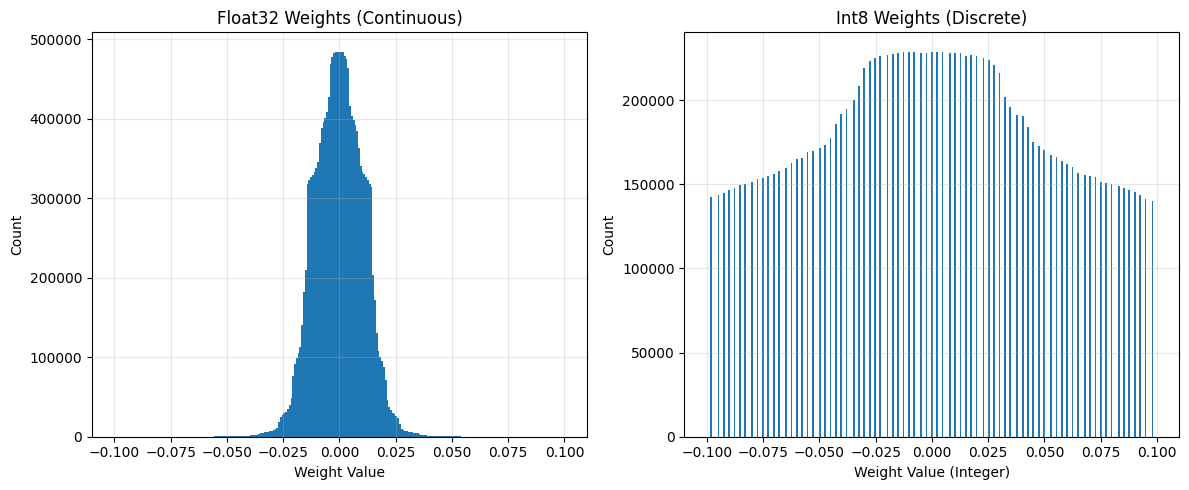


DISCRETE NATURE OF QUANTIZED WEIGHTS

Top 10 most common weight values:
     0: 228,915 occurrences
    -4: 228,831 occurrences
     2: 228,706 occurrences
     1: 228,561 occurrences
    -3: 228,500 occurrences
    -5: 228,441 occurrences
    -1: 228,372 occurrences
     4: 228,361 occurrences
    -2: 228,224 occurrences
     5: 228,041 occurrences

Weight value statistics:
  Most common: 0 (228,915 occurrences)
  Least common: -118 (1 occurrences)
  Zero weights: 228,915


In [ ]:
print("\n" + "=" * 60)
print("CHECKING WEIGHT HISTOGRAM DIFFERENCE")
print("=" * 60)


# Collect weights from both models
def get_all_weights(model):
    weights = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            w = module.weight.data.cpu().numpy().ravel()
            weights.append(w)
    return np.concatenate(weights) if weights else np.array([])


float_weights = get_all_weights(unet)
quant_weights = get_all_weights(unet_quantized)

print(f"Float32 weights: {len(float_weights):,} parameters")
print(f"Int8 weights: {len(quant_weights):,} parameters")

# Check integer nature
is_integer = np.allclose(quant_weights, np.round(quant_weights), atol=1e-3)
print(f"\nQuantized weights are integers: {is_integer}")
if is_integer:
    unique_vals = len(np.unique(quant_weights))
    min_val = int(np.min(quant_weights))
    max_val = int(np.max(quant_weights))
    print(f"Unique integer values: {unique_vals}")
    print(f"Integer range: [{min_val}, {max_val}]")

# ----------------------------
# Create histogram (fig, ax)
# ----------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

nbins = 127 * 2
bins = np.linspace(-0.1, 0.1, nbins)

# Float weights
ax[0].hist(float_weights, bins=bins)
ax[0].set_title("Float32 Weights (Continuous)")
ax[0].set_xlabel("Weight Value")
ax[0].set_ylabel("Count")
ax[0].grid(True, alpha=0.3)

# Quantized weights
abs_max = np.max(np.abs(quant_weights))
print(f"Absolute max: {abs_max}")

# Put quant weights back into original scale (as in your code)
quant_weights_original_scale = quant_weights * unet_quantized.input_scale

ax[1].hist(quant_weights * (np.max(float_weights) / np.max(quant_weights)), bins=bins)
ax[1].set_title("Int8 Weights (Discrete)")
ax[1].set_xlabel("Weight Value (Integer)")
ax[1].set_ylabel("Count")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Show discrete nature clearly
# ----------------------------
print("\n" + "=" * 60)
print("DISCRETE NATURE OF QUANTIZED WEIGHTS")
print("=" * 60)

# Get unique values and counts
unique_values, counts = np.unique(quant_weights, return_counts=True)

print(f"\nTop 10 most common weight values:")
sorted_idx = np.argsort(counts)[::-1]
for i in range(min(10, len(unique_values))):
    idx = sorted_idx[i]
    print(f"  {int(unique_values[idx]):4d}: {counts[idx]:,} occurrences")

print(f"\nWeight value statistics:")
print(
    f"  Most common: {int(unique_values[sorted_idx[0]])} ({counts[sorted_idx[0]]:,} occurrences)"
)
print(
    f"  Least common: {int(unique_values[sorted_idx[-1]])} ({counts[sorted_idx[-1]]:,} occurrences)"
)
print(f"  Zero weights: {counts[unique_values == 0][0] if 0 in unique_values else 0:,}")

In [ ]:
print("\n" + "=" * 60)
print("CHECKING OUTPUT SCALES IN QUANTIZED MODEL")
print("=" * 60)

# Check which layers have output scales
layers_with_output_scale = 0
for name, module in unet_quantized.named_modules():
    if hasattr(module, "output_scale"):
        layers_with_output_scale += 1
        print(f"{name}: output_scale = {module.output_scale:.6f}")

print(f"\nTotal layers with output_scale: {layers_with_output_scale}/31")

# Check the first few layers' output scales
print("\nFirst few layers' output scales:")
test_layers = [
    "inc.double_conv.0",
    "inc.double_conv.3",
    "downs.0.maxpool_conv.1.double_conv.0",
]
for layer_name in test_layers:
    for name, module in unet_quantized.named_modules():
        if layer_name in name:
            output_scale = getattr(module, "output_scale", None)
            weight_scale = getattr(module.weight, "scale", None)
            print(f"{layer_name}:")
            print(
                f"  weight_scale: {weight_scale:.4f}"
                if weight_scale
                else "  No weight scale"
            )
            print(
                f"  output_scale: {output_scale:.6f}"
                if output_scale
                else "  No output scale"
            )
            break


CHECKING OUTPUT SCALES IN QUANTIZED MODEL
inc.double_conv.0: output_scale = 0.003027
inc.double_conv.3: output_scale = 0.006551
downs.0.maxpool_conv.1.double_conv.0: output_scale = 1.000000
downs.0.maxpool_conv.1.double_conv.3: output_scale = 1.000000
downs.1.maxpool_conv.1.double_conv.0: output_scale = 1.000000
downs.1.maxpool_conv.1.double_conv.3: output_scale = 1.000000
downs.2.maxpool_conv.1.double_conv.0: output_scale = 1.000000
downs.2.maxpool_conv.1.double_conv.3: output_scale = 1.000000
downs.3.maxpool_conv.1.double_conv.0: output_scale = 1.000000
downs.3.maxpool_conv.1.double_conv.3: output_scale = 1.000000
downs.4.maxpool_conv.1.double_conv.0: output_scale = 1.000000
downs.4.maxpool_conv.1.double_conv.3: output_scale = 1.000000
downs.5.maxpool_conv.1.double_conv.0: output_scale = 1.000000
downs.5.maxpool_conv.1.double_conv.3: output_scale = 1.000000
downs.6.maxpool_conv.1.double_conv.0: output_scale = 1.000000
downs.6.maxpool_conv.1.double_conv.3: output_scale = 1.000000
ups

## Second Approach

val loss train loss

# Test Set Evaluation

In [ ]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet, device=device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim=True)

print(f"Error on the testing set: {errors.mean()}")

Error on the testing set: 0.0014955681981518865


In [ ]:
# Convert to numpy arrays
inputs_cpu = inputs.cpu().numpy()
predictions_cpu = predictions.cpu().numpy()
truths_cpu = truths.cpu().numpy()
masks_cpu = masks.cpu().numpy()
errors_cpu = errors.cpu().numpy()

/tmp/ipykernel_1440063/825397190.py:14: RuntimeWarning: invalid value encountered in divide
  residual_x = (truth_x - predicted_x) / truth_x
/tmp/ipykernel_1440063/825397190.py:15: RuntimeWarning: invalid value encountered in divide
  residual_y = (truth_y - predicted_y) / truth_y


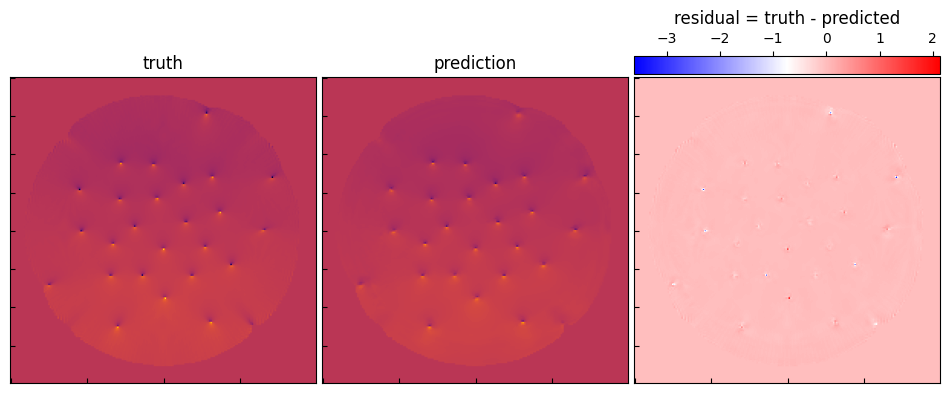

In [ ]:
# Visualize a prediction
idx = 100
vmin = truths_cpu.min()
vmax = truths_cpu.max()
fig, ax = plt.subplots(1, 3, figsize=(12, 8), dpi=100)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.02, wspace=0.02)
truth_x = truths_cpu[idx, 0]
truth_y = truths_cpu[idx, 1]

predicted_x = predictions_cpu[idx, 0] * (1 - masks_cpu[idx, 0])
predicted_y = predictions_cpu[idx, 1] * (1 - masks_cpu[idx, 1])

residual_x = (truth_x - predicted_x) / truth_x
residual_y = (truth_y - predicted_y) / truth_y

# Only where truth != 0
percentage_error_x = np.zeros_like(truth_x)
mask = truth_x != 0
percentage_error_x[mask] = 100 * (truth_x[mask] - predicted_x[mask]) / truth_x[mask]

residual = truth_x - predicted_x
ax[0].imshow(truth_x, vmin=vmin, vmax=vmax, cmap="inferno")
ax[1].imshow(predicted_x, vmin=vmin, vmax=vmax, cmap="inferno")
# ax[3].imshow(truth_y , vmin = vmin, vmax = vmax)
# ax[4].imshow(predicted_y, vmin = vmin, vmax = vmax)

# show the residual in the 3 column
resim = ax[2].imshow(residual, cmap="bwr")
# ax[5].imshow(residual_y, vmin = -1, vmax = 1, cmap="bwr")
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

# make an inset axis for ax[2]
cbar_inset = ax[2].inset_axes([0, 1.01, 1, 0.06])

# make a colorbar using cbar_inset

cbar = fig.colorbar(resim, cax=cbar_inset, orientation="horizontal")
cbar_inset.set_title(r"residual = truth - predicted")
# put ticks on top of the cbar
cbar_inset.xaxis.set_ticks_position("top")
# fig.colorbar(resim, ax=ax[2], location='top', label='Residual Value', fraction=0.046, pad=0.04)


ax[0].set_title("truth")
ax[1].set_title("prediction")


plt.savefig(
    os.path.join(data_loc, "final_example_residual.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

Text(0, 0.5, 'Frequency')

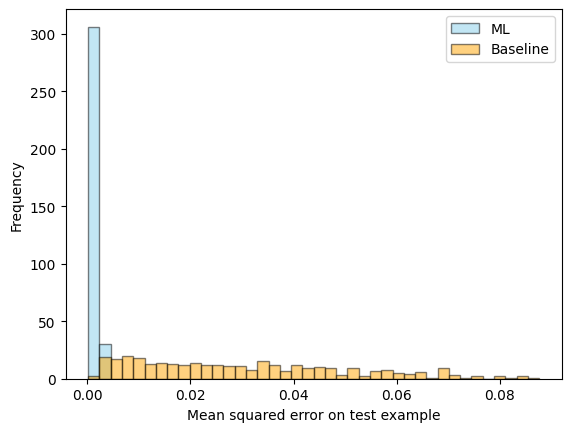

In [ ]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths_cpu, axis=(-1, -2, -3))
all_errors = np.concatenate([errors_cpu, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(
    errors_cpu,
    alpha=0.5,
    bins=bin_edges,
    label="ML",
    color="skyblue",
    edgecolor="black",
)
plt.hist(
    baseline_errors,
    alpha=0.5,
    bins=bin_edges,
    label="Baseline",
    color="orange",
    edgecolor="black",
)
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")